## Zaawansowane Metody Inteligencji Obliczeniowej
# Zadanie domowe 3 (30 pkt.)
### Prowadzący: Michał Kempka, Marek Wydmuch
### Autor: Adam Marciniak + 141273

## Wprowadzenie

Zadania będą polegały na implementacji różnych wariantów algorytmu Q-Learning dla dwóch środowisk z biblioteki OpenAI Gym (https://gym.openai.com): `CartPole` i `LunarLander`.

#### Uwaga: Możesz dowolnie modyfikować elementy tego notebooka (wstawiać komórki i zmieniać kod) o ile nie napisano gdzieś inaczej.

In [1]:
# Zainstaluj bibliotekę OpenAI Gym i PyTorch
!pip install gym torch matplotlib numpy box2d
# W wypadku problemów z działaniem `env.render()` na macOS Big Sur uruchom również poniższą linię
#!pip install pyglet==1.5.15

     |████████████████████████████████| 1.3 MB 4.8 MB/s 


### Środowisko `CartPole` i `LunarLander`

Poniższy kod demonstruje działanie środowiska `CartPole` (https://gym.openai.com/envs/CartPole-v1) i `LunarLander` (https://gym.openai.com/envs/LunarLander-v2/).

In [2]:
# Zobacz jak działają środowiska na przykładzie 1000 kroków
import gym

#env = gym.make("CartPole-v1")
env = gym.make("LunarLander-v2")
observation = env.reset()
for _ in range(1000):
    # env.render() <- render() nie działa w Google Colab
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    if done:
        observation = env.reset()
env.close()

In [3]:
# Zobacz jakim typem są obserwacje (reprezentacja stanu) oraz jaka jest przestrzeń akcji:
print("Przestrzeń stanów:", env.observation_space)
print("Rozmiar wektora reprezntującego stany:", env.observation_space.shape)
print("Ostatnia obserwacja:", type(observation), observation)
print("Przestrzeń akcji:", env.action_space)
print("Ilość możliwych akcji:", env.action_space.n)

Przestrzeń stanów: Box(-inf, inf, (8,), float32)
Rozmiar wektora reprezntującego stany: (8,)
Ostatnia obserwacja: <class 'numpy.ndarray'> [ 0.00209951  1.4056747   0.21264279 -0.23313707 -0.00242603 -0.04816677
  0.          0.        ]
Przestrzeń akcji: Discrete(4)
Ilość możliwych akcji: 4


### Interface agenta

Wszystkie implementacje będą w oparciu o klasę `Agent` przedstawioną poniżej. Powinna ona implementować dwie metody: 1) `process_transition`, która będzie wykorzystywana tylko podczas uczenia by przekazać do agenta krotkę zawierającą obserwacje, podjętą akcję, nagrodę i następujący stan oraz informację czy jest on terminalny. 2) `get_action` która na podstawie obserwacji zwraca akcję, dodatkowy argument informuję Agenta czy jest w aktualnie podczas uczenia czy ewaluacji.

Poniżej znajdziiesz też funkcję `run_agent_in_env`, która korzysta z opisanego wyżej obiektu agenta w celu jego uczenia lub ewaluacji (podobną będziemy używać my podczas sprawdzania wszych rozwiązań). Możecie ją modyfikować jeśli widzicie taką potrzebę. Dopisaliśmy do tej funkcji rysowanie wykresu nagród z minionych epizodów, który uaktualnia się co ich zadaną liczbę.

In [4]:
class Agent:
    def __init__(self, env):
        self.observation_space = env.observation_space
        self.action_space = env.action_space
    
    def process_transition(self, observation, action, reward, next_observation, done):
        raise NotImplementedError()
        
    def get_action(self, observation, learning):
        raise NotImplementedError()

In [5]:
from time import time
import matplotlib.pylab as plt
from IPython import display
%matplotlib inline


def plot_rewards(rewards, epsilons):
    fig, ax = plt.subplots(figsize=(14,6))
    ax.plot(rewards, label='reward', zorder=1)
    # ax.set_ylim(0, 500)
    ax.legend(loc='upper left')
    
    ax2 = ax.twinx()
    # ax2.plot(alphas, label='alpha', color='k')
    ax2.plot(epsilons, label='epsilon', color='r')
    ax2.set_ylim(0, 1)
    ax2.legend(loc='upper right')
    display.display(plt.gcf())
    display.clear_output(wait=True)

    
def run_agent_in_env(env, agent, episodes, learning=False, plot=False, plot_interval=1000, time_limit=None):
    rewards = []
    # alphas = []
    epsilons = []
    start = time()
    for episode in range(episodes):
        observation = env.reset()
        total_reward = 0
        done = False
        while not done :
            # Zapytajmy agenta o akcje dla aktualnego stanu
            action = agent.get_action(observation, learning)
            
            # Wykonajmy akcje
            next_observation, reward, done, _ = env.step(action)
            total_reward += reward
            
            # Jeśli się uczymy, przekażmy przejście do agenta
            if learning:
                agent.process_transition(observation, action, reward, next_observation, done)
            
            observation = next_observation
        rewards.append(total_reward)
        # alphas.append(agent.alpha)
        epsilons.append(agent.eps)
        
        # Wyświetl na wykresie nagrody otrzymane po kolei w epizodach
        if episode % plot_interval == 0:
            if plot:
                plot_rewards(rewards, epsilons)
            else:
                print(f"Finished episode #{episode}")
        if time_limit is not None:
            if time() - start > time_limit:
                break
    return rewards    

## Zad. 3.1 - Tabularyczny Q-Learning (5 pkt.)

W komórkach poniżej zaimplementuj prosty tabularyczny Q-Learning dla środowiska `CartPole`, korzystający podczas uczenia się z polityki epsilon-greedy. Ponieważ środowisko `CartPole` ma ciągłą przestrzeń stanów, musisz dokonać odpowiedniej dyskretyzacji stanów.

Uwagi:
- Dobra polityka dająca średni wynik powyżej 200, środowisko ma limit na 500 iteracji. Polityka dająca średni wynik blisko 500 jest więc bardzo dobra.
- Uczenie nie powinno trwać więcej niż 10-15 minut na CPU.
- Postaraj się dobrać i ustawić w `__init__` takie parametry by Twój Agent uczył się i działał jak najlepiej. Są one pod Twoją kontrolą w klasie, więc możesz je odpowiednio kontrolować w trakcie uczenia.


#### Uwaga: nie zmieniaj nazwy klasy `TabularQLearningAgent`, ani pozycyjnych (tych bez wartości domyślnych) argumentów jej metod, możesz dopisywać argumenty z wartościami domyślnymi oraz oczywiście pomocnicze metody do klasy. Pomocnicze metody powinny być w tej samej komórce (sprawdzarka wyciągnie ze zgłoszonego notebooka wyłącznie komórkę z klasą `TabularQLearningAgent`, kod w innych komórkach nie będzie widziany przez sprawdzarkę!). Nie dopisuj do komórki z klasą innego kodu.


import numpy as npOdpowiedzi: Miejsce na Twoje odpowiedzi

In [12]:
import numpy as np


class TabularQLearningAgent(Agent):
    def __init__(self, env, gamma=1.1,
                 eps=0.7, eps_decay=0.999, eps_min=0.001,
                 alpha=0.3, alpha_decay=0.999, alpha_min=0.01):
        super().__init__(env)
        self.gamma = gamma  # współczynnik dyskontujący

        self.eps = eps  # współczynnik eksploracji
        self.eps_decay = eps_decay   # wygaszanie współczynnika eskploracji
        self.eps_min = eps_min

        self.alpha = alpha  # learning rate
        self.alpha_decay = alpha_decay  # wygaszanie learning rate
        self.alpha_min = alpha_min

        self.n_bins = np.array([14, 22, 44, 12])
        self.limits = np.array([4.8, 4, 0.42, 4])
        self.bins = self.prepare_bins()
        self.Q = np.zeros((*self.n_bins, env.action_space.n))
    
    def process_transition(self, observation, action, reward, next_observation, done):
        """Wykorzystywana tylko podczas uczenia by przekazać do agenta krotkę
        zawierającą obserwacje, podjętą akcję, nagrodę i następujący stan
        oraz informację czy jest on terminalny."""
        s = self.discretize(observation)
        next_s = self.discretize(next_observation)
        if done:
            self.Q[next_s] = 0
            if reward < 1:  # koniec - tyczka się przewróciła, a nie osiągnięto limit iteracji 
                reward = -100
            self.eps = max(self.eps_decay*self.eps, self.eps_min)
            self.alpha = max(self.alpha_decay*self.alpha, self.alpha_min)
        self.Q[s][action] += self.calc_q(s, action, reward, next_s)
        
    def get_action(self, observation, learning):
        """Na podstawie obserwacji zwraca akcję, dodatkowy argument informuje Agenta
        czy jest w aktualnie podczas uczenia czy ewaluacji."""
        if learning and np.random.rand() < self.eps:
            return np.random.randint(self.action_space.n)
        s = self.discretize(observation)
        a = np.argmax(self.Q[s])
        return a

    def discretize(self, state):
        """Dopasuj obserwację do jednego z dyskretnych stanów"""
        discrete = []
        clipped_s = np.clip(state, -self.limits, self.limits)
        for i, obs in enumerate(clipped_s):
            discrete.append(np.digitize(obs, self.bins[i]) - 1)
        return tuple(discrete)

    def calc_q(self, s, a, r, next_s):
        return self.alpha * (r + self.gamma*np.max(self.Q[next_s]) - self.Q[s][a])

    def prepare_bins(self):
        bins = []
        for n, limit in zip(self.n_bins, self.limits):
            dim_bins = np.linspace(-limit/2, limit/2, n-2)
            dim_bins = np.concatenate([[-limit], dim_bins, [limit]])
            bins.append(dim_bins)
        return bins


Time elapsed: 300.784s


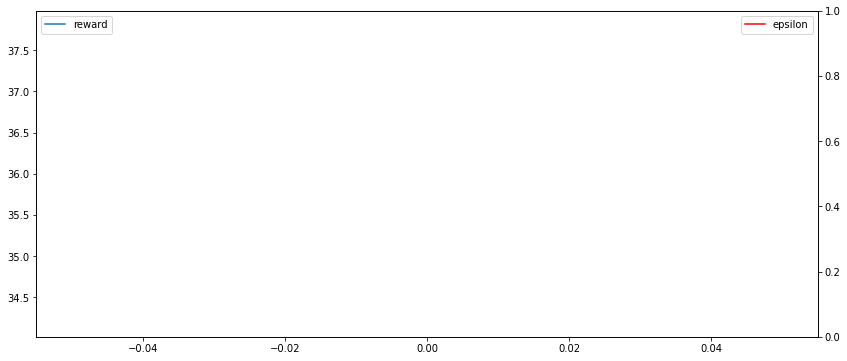

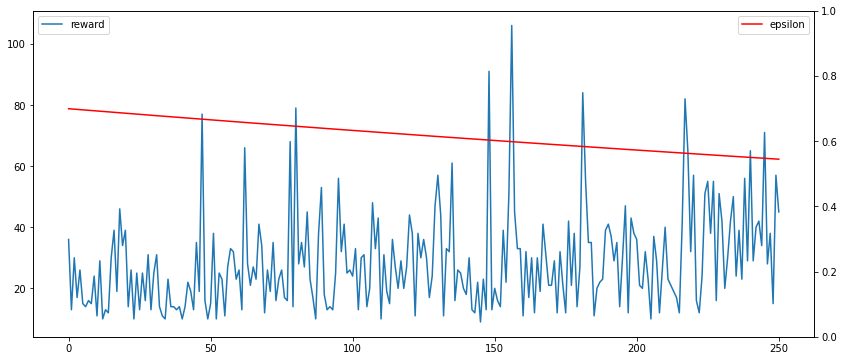

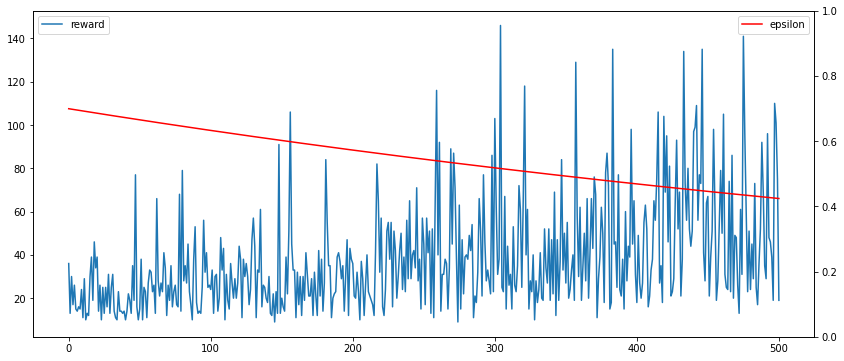

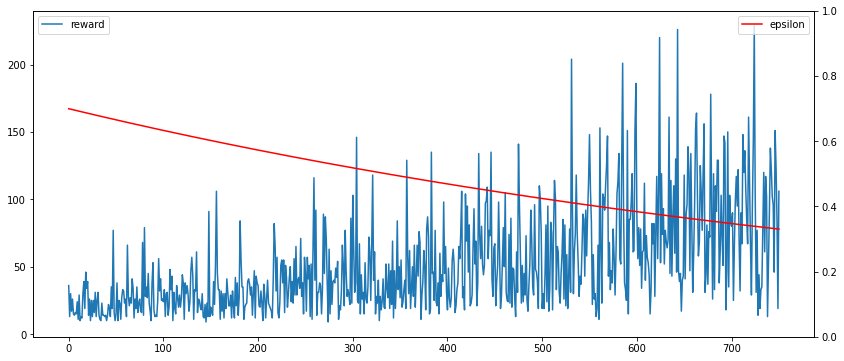

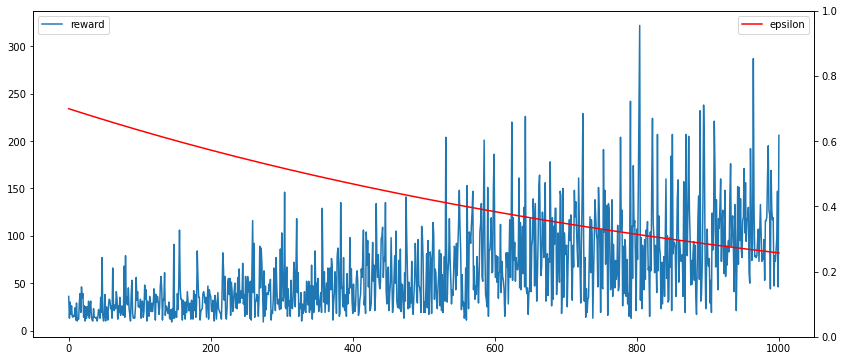

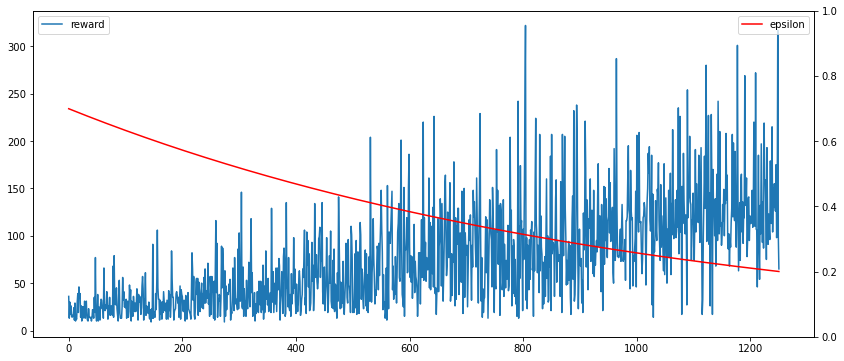

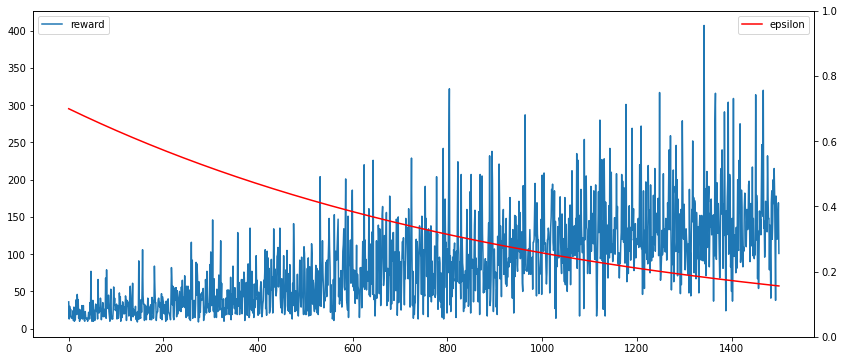

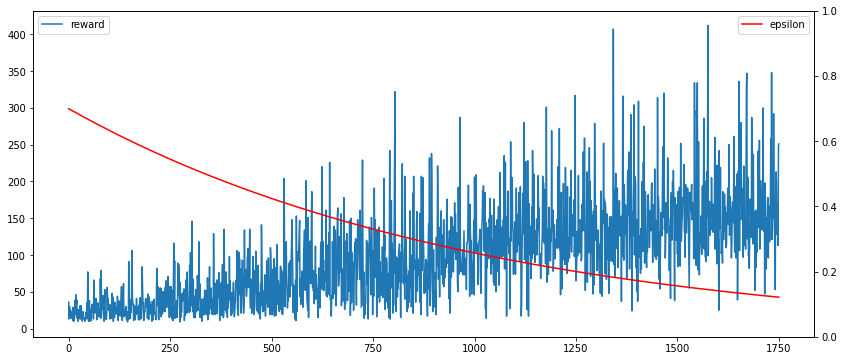

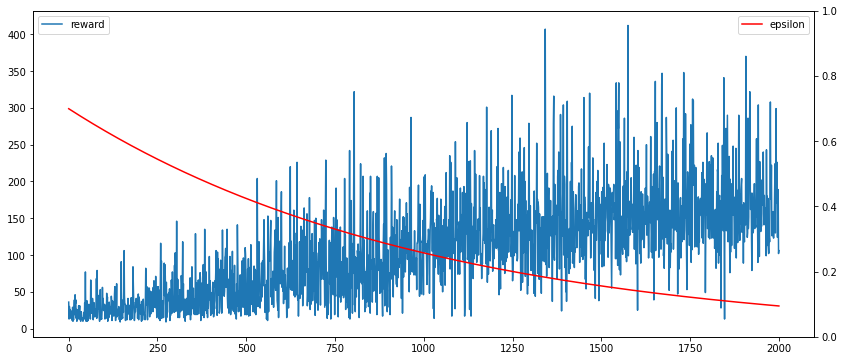

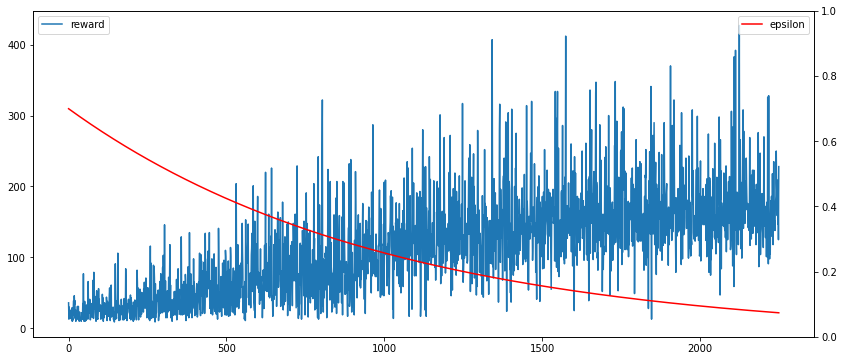

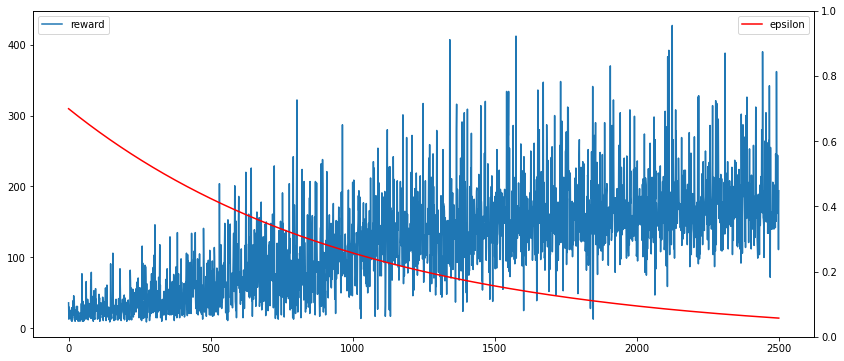

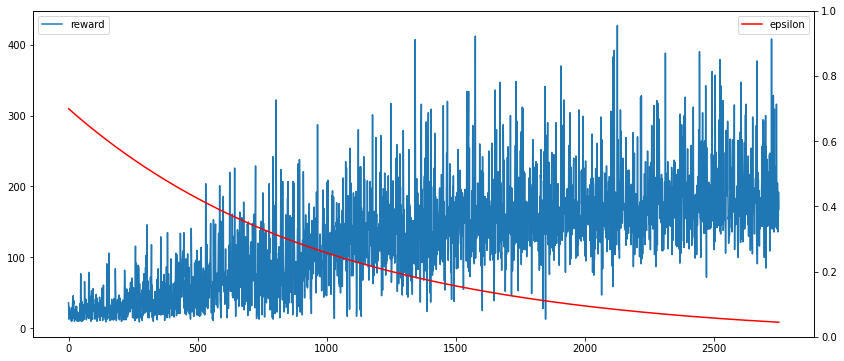

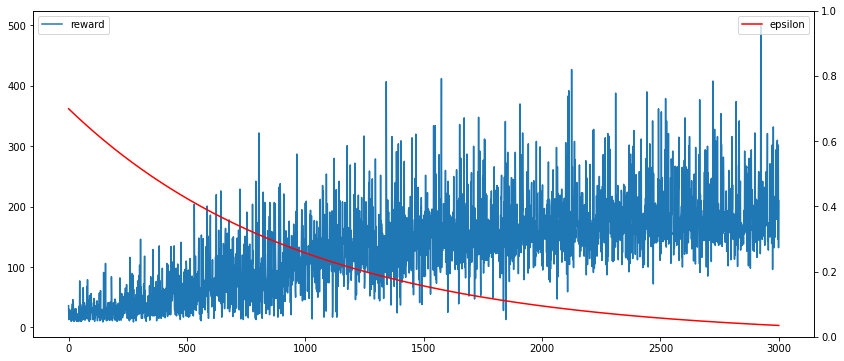

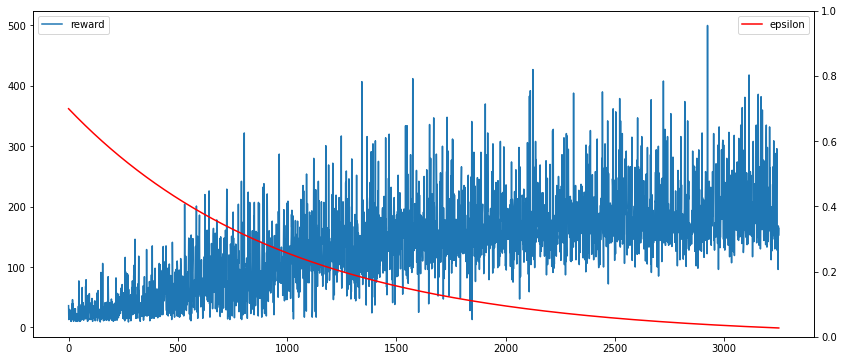

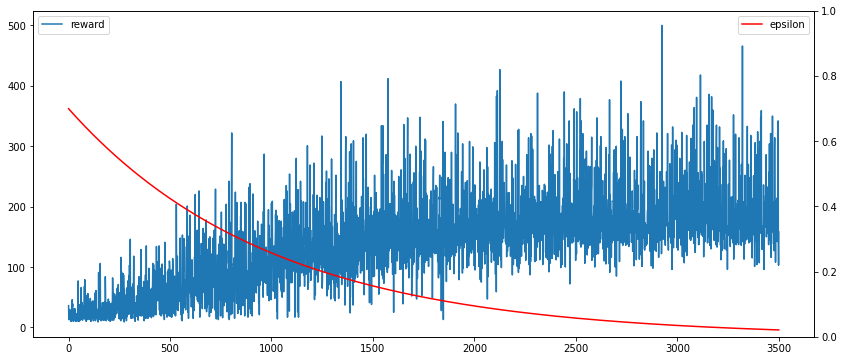

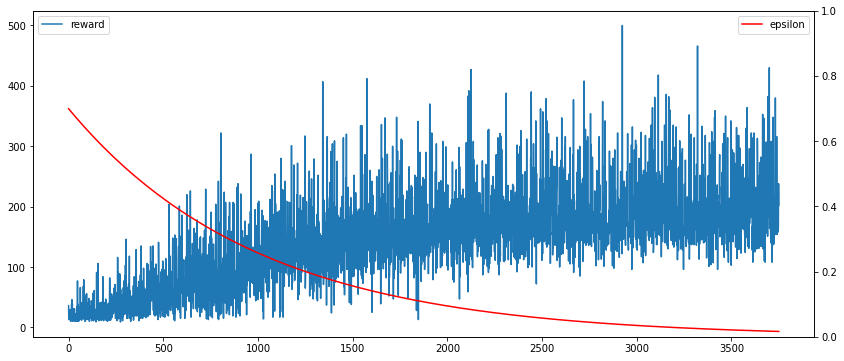

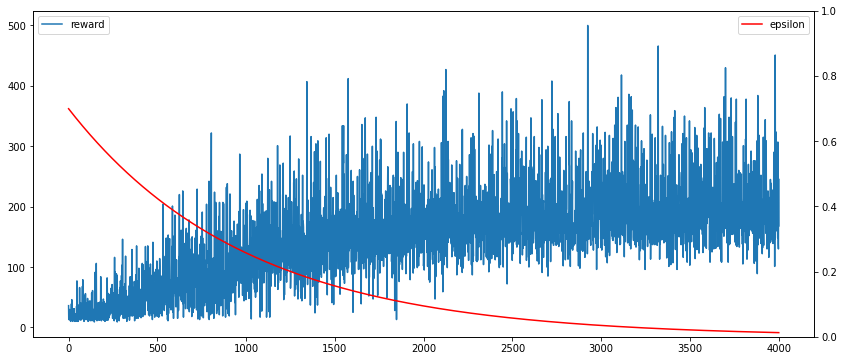

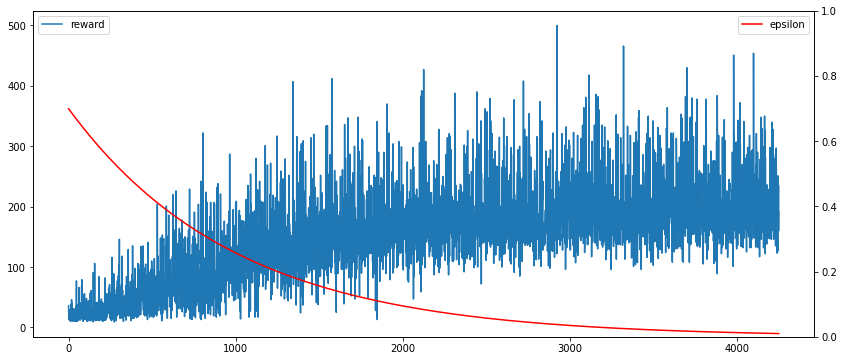

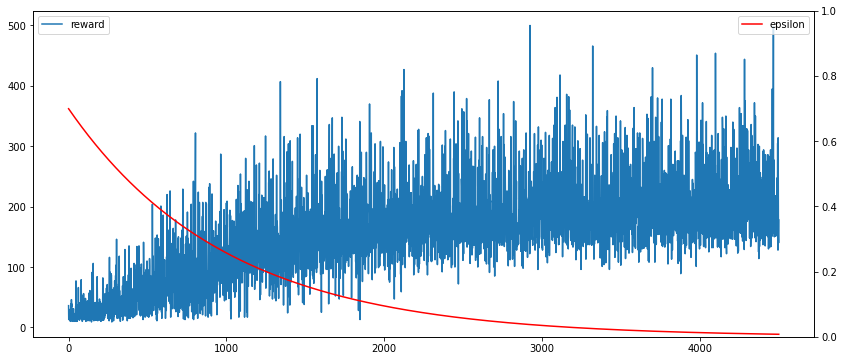

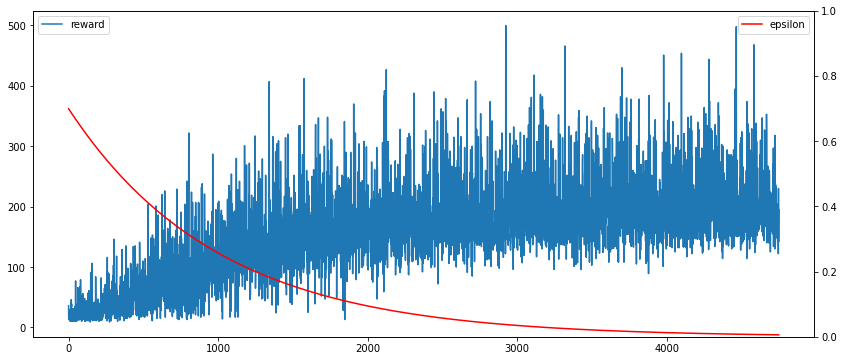

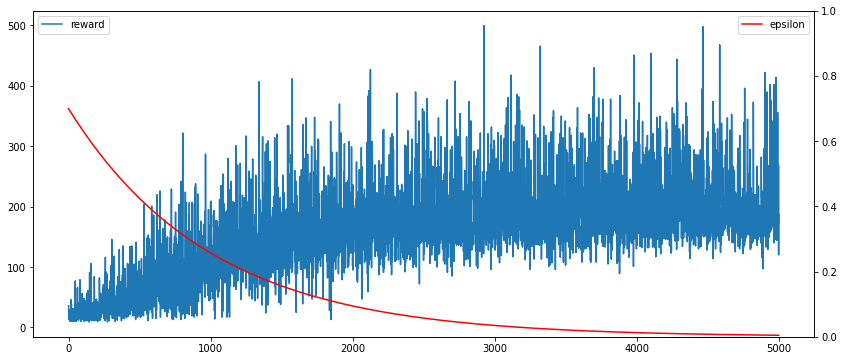

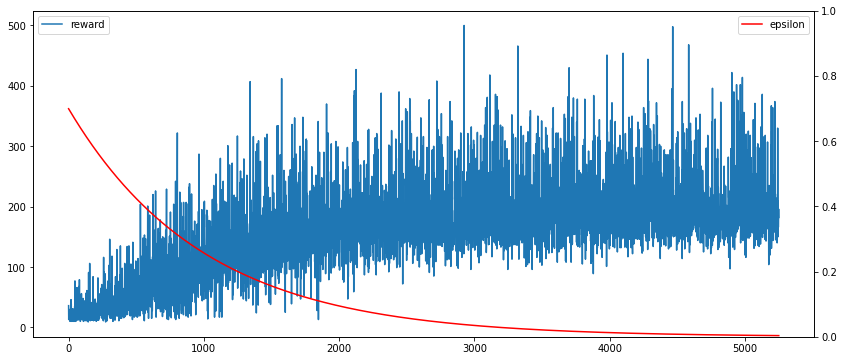

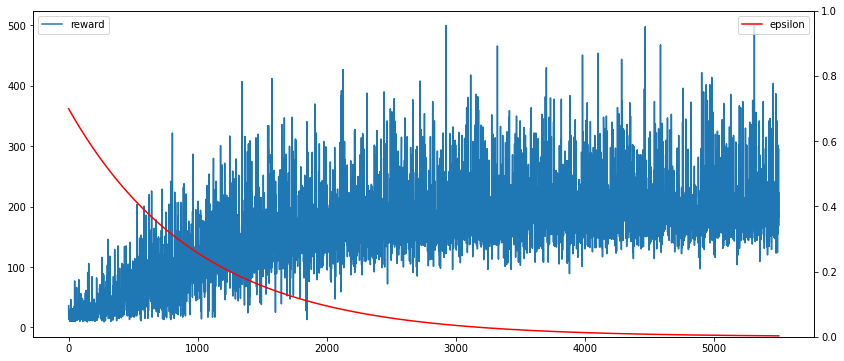

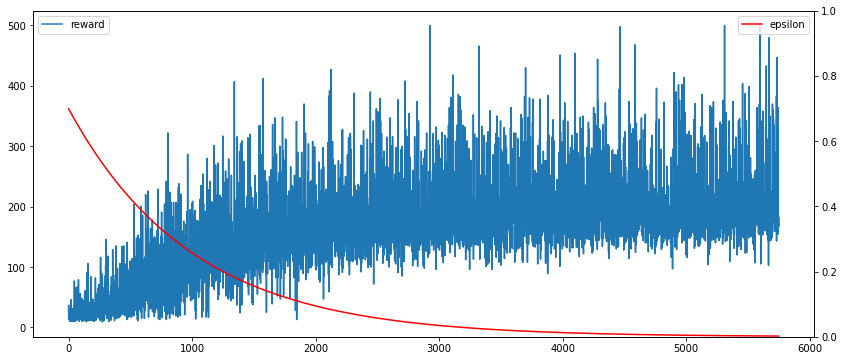

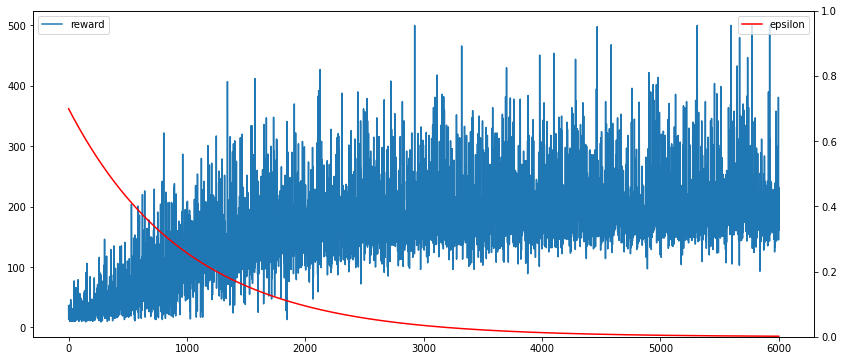

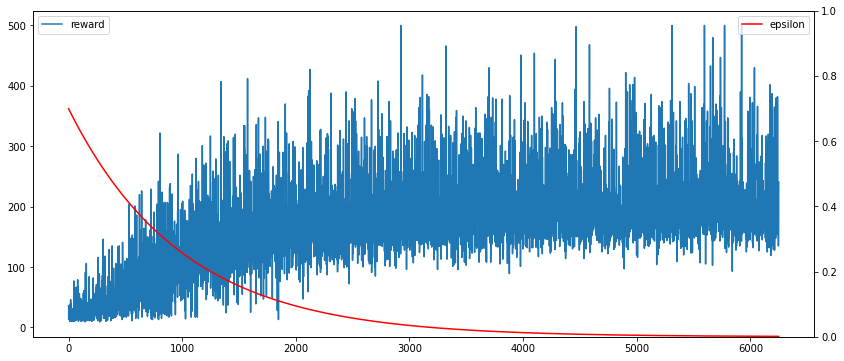

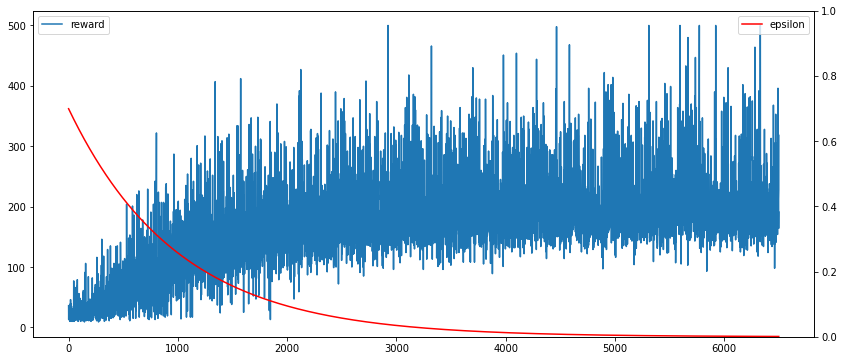

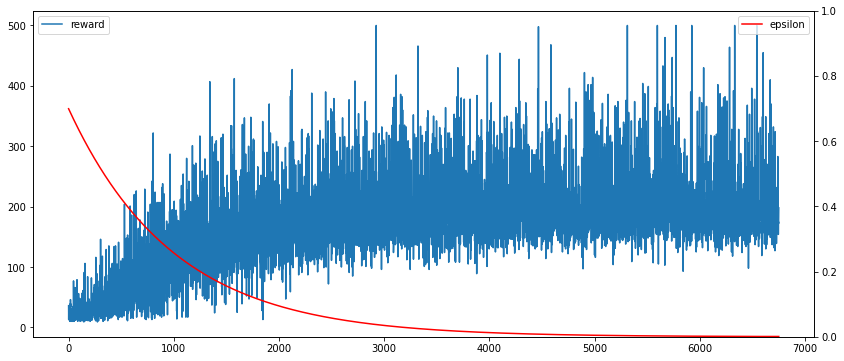

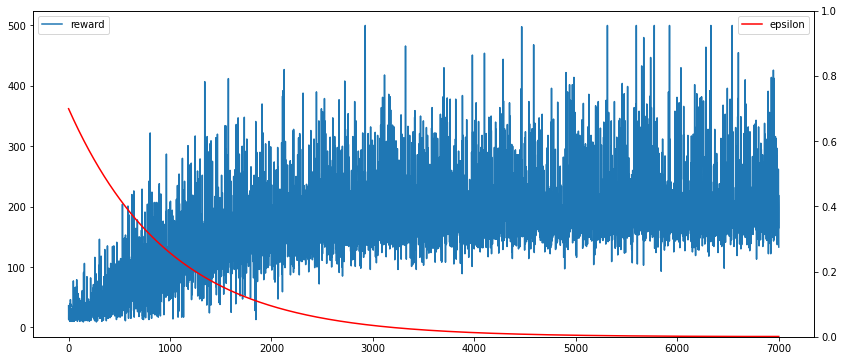

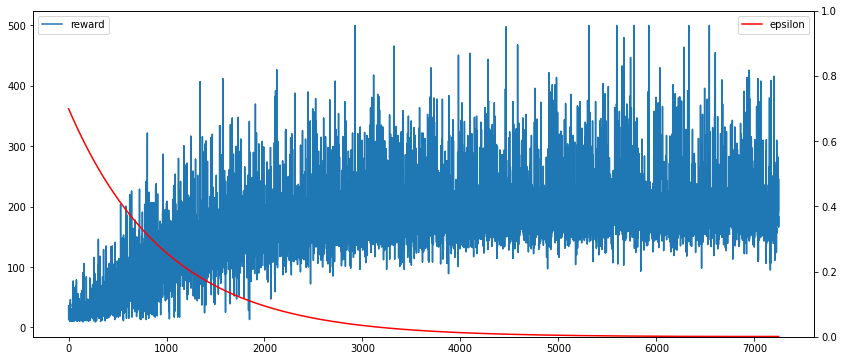

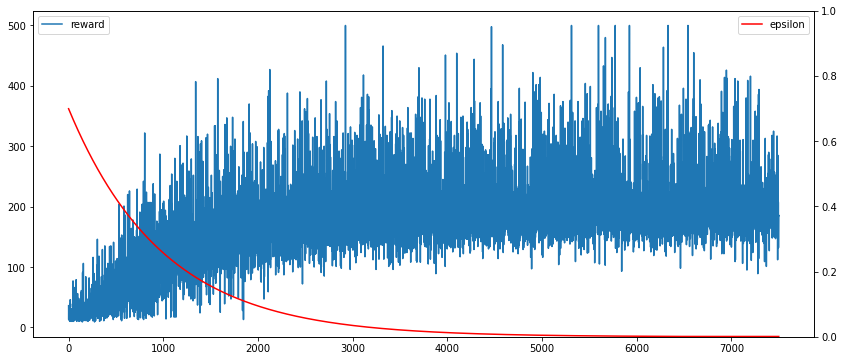

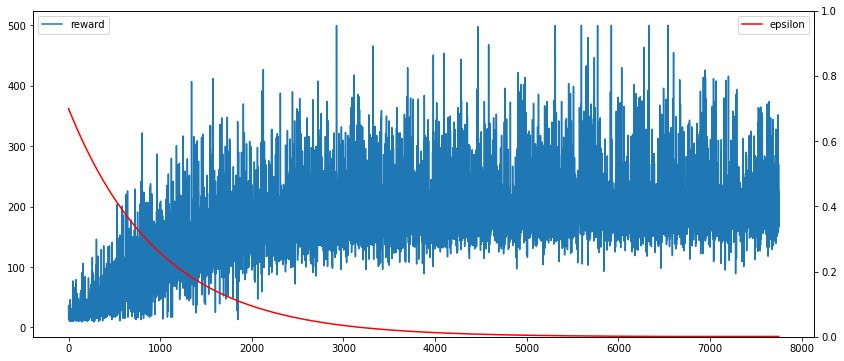

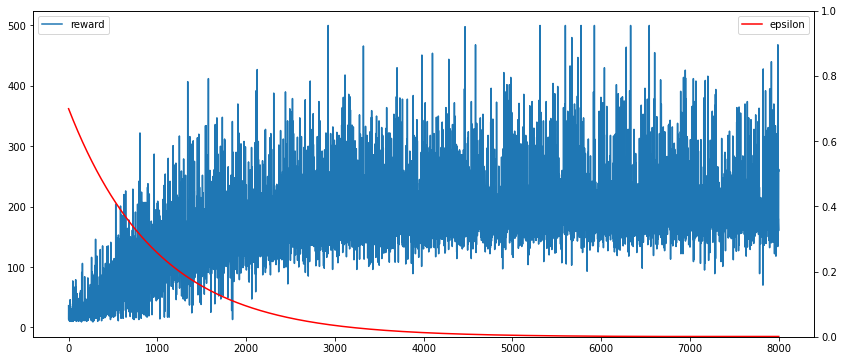

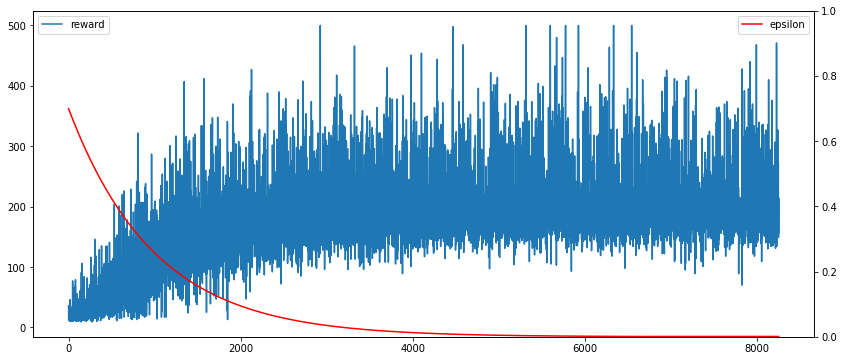

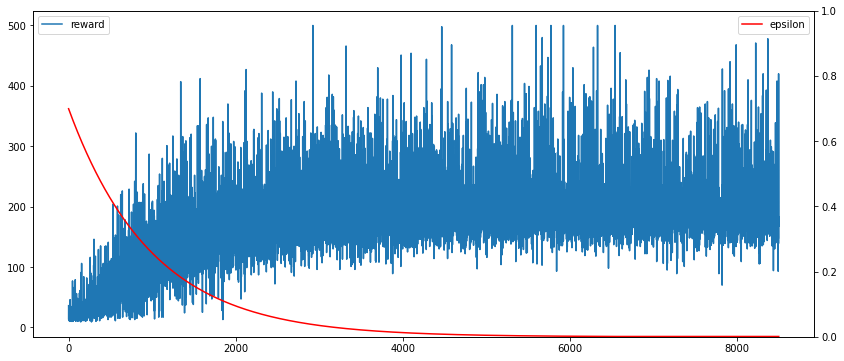

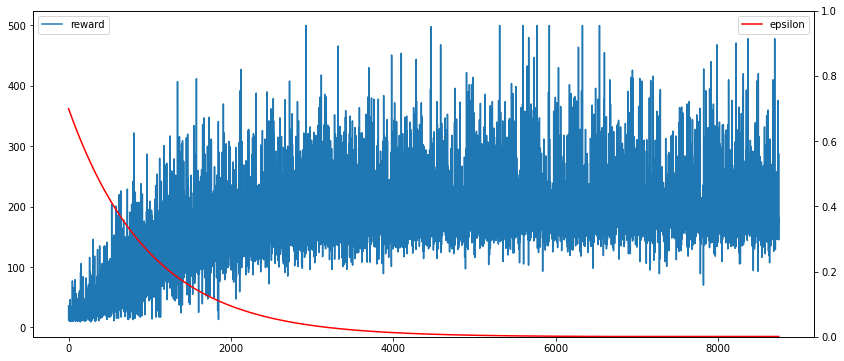

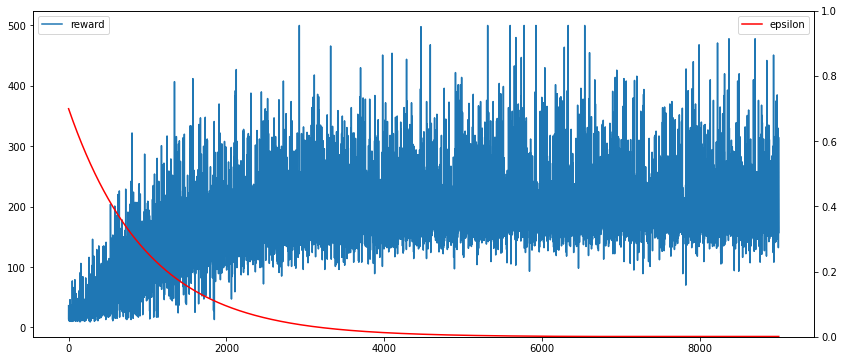

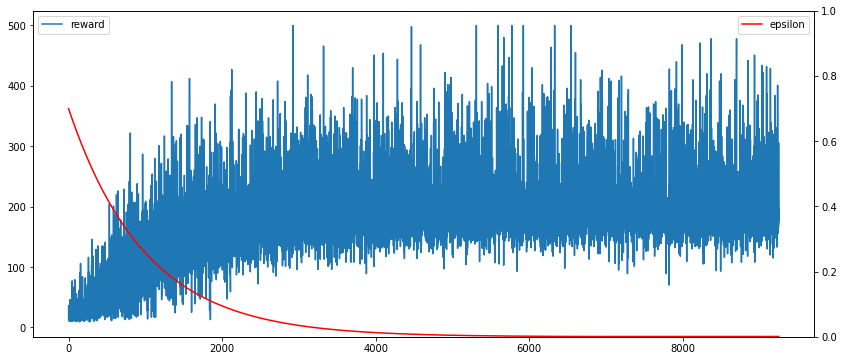

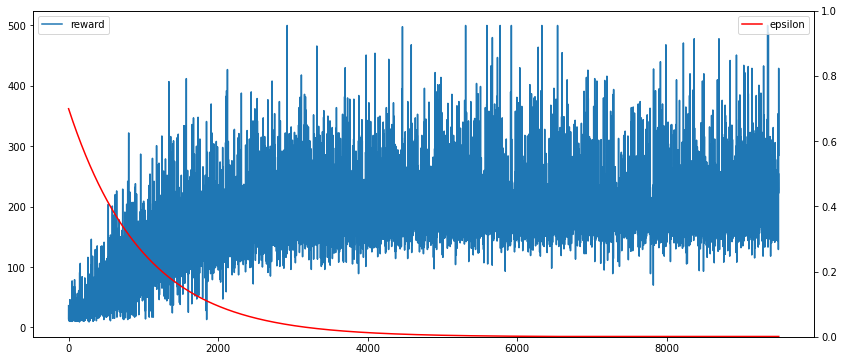

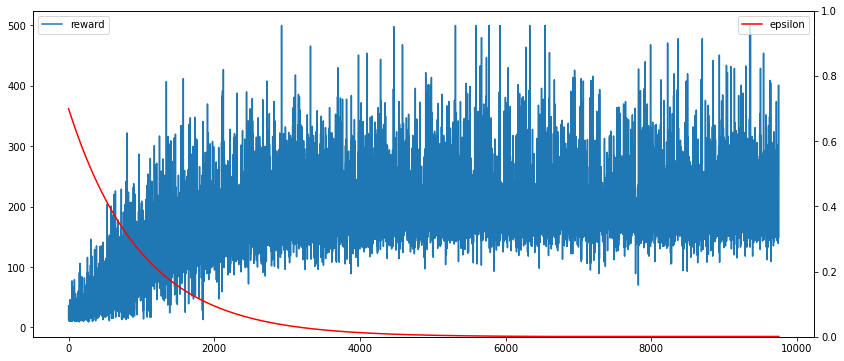

In [13]:
# Uczenie/testowania agenta
from time import time

env = gym.make("CartPole-v1")
agent = TabularQLearningAgent(env)
start = time()
rewards = run_agent_in_env(env, agent, 10000, learning=True, plot=True, plot_interval=250)
print(f"Time elapsed: {np.round(time() - start, 3)}s")

Finished episode #0
Finished episode #250
Finished episode #500
Finished episode #750
203.44


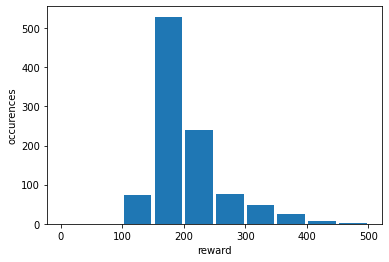

In [14]:
actual_rewards = run_agent_in_env(env, agent, 1000, learning=False, plot=False, plot_interval=250)
print(np.mean(actual_rewards))
plt.hist(actual_rewards, bins=[*range(0,501,50)], rwidth=0.9)
plt.xlabel('reward')
plt.ylabel('occurences')
plt.show()

In [16]:
# eps=0.8, alpha=0.6, decay=0.9995, min=0, n_bins=[14 22 44 22] --> 134.8638
# eps=0.75, eps_decay=0.999, eps_min=0.02, alpha=0.3, alpha_decay=0.9995, alpha_min=0.02, n_bins=[14 12 44 12] --> 135.9095
# gamma=1.1, eps=0.75, eps_decay=0.999, eps_min=0.01, alpha=0.3, alpha_decay=0.999, alpha_min=0.001, n_bins=[14 22 44 12] --> 168.4556
# gamma=1.1, eps=0.7, eps_decay=0.999, eps_min=0.001, alpha=0.3, alpha_decay=0.999, alpha_min=0.001, n_bins=[14 22 44 12] --> 179.8326
# gamma=1.1, eps=0.7, eps_decay=0.999, eps_min=0.001, alpha=0.3, alpha_decay=0.999, alpha_min=0.001, n_bins=[14 22 44 12], Q[next_s] := -1 if done --> 168.6092
# gamma=1.1, eps=0.7, eps_decay=0.999, eps_min=0.001, alpha=0.3, alpha_decay=0.999, alpha_min=0.01, n_bins=[14 22 44 12], reward := -100 if done --> 211.2369
# gamma=1.1, eps=0.7, eps_decay=0.999, eps_min=0.01, alpha=0.3, alpha_decay=0.999, alpha_min=0.05, n_bins=[14 22 44 12], reward := -100 if done --> 173.5559
print(f"gamma={agent.gamma}, eps=0.7, eps_decay={agent.eps_decay}, eps_min={agent.eps_min}, alpha=0.3, alpha_decay={agent.alpha_decay}, alpha_min={agent.alpha_min}, n_bins={agent.n_bins} --> {np.mean(actual_rewards)}")

gamma=1.1, eps=0.7, eps_decay=0.999, eps_min=0.001, alpha=0.3, alpha_decay=0.999, alpha_min=0.01, n_bins=[14 22 44 12] --> 203.44


## Zad. 3.2 - Q-Learning z aproksymacją (25 pkt.)

W komórkach poniżej zaimplementuj Q-Learning z aproksymacją dla środowiska `LunarLander`, korzystający podczas uczenia się z polityki epsilon-greedy, a jako aproksymatora użyj prostej sieć neuronową zaimplementowanej z wykorzystaniem biblioteki PyTroch. Zaimplementuj następujące ulepszenia algorytmu Q-Learning:
- replay memory i uczenia batchowe zamiast uczenia online
- network freezing
- double q-learning

Porównaj ze sobą różne warianty algorytmu (nie duplikuj swojej implementacji, dodaj odpowiednie argumenty w konstruktorze, które będą włączać/wyłączać odpowiednie rozszerzenie), zademonstruj oczywiście swoje wyniki pozostawiając odpowiedni output z komórek oraz je skomentuj. Opisz również, jak dokonałeś doboru parametrów Twojego modelu.

Uwagi:
- Dobra polityka powinna mieć średnią bliską 100, bardzo dobra bliską 200.
- Uczenie nie powinno trwać więcej niż 10-15 minut (przy dobrze zaimplementowanych rozszerzeniach powinno być dużo szybsze) na CPU (możesz oczywiście użyć GPU jeśli masz taką możliwość, ale zadbaj, by domyślnie Twoja implementacja działała na CPU).
- Postaraj się dobrać i ustawić w `__init__` takie parametry (w tym architekturę sieci neuronowej) by Twój Agent uczył się i działał jak najlepiej. Są one pod Twoją kontrolą w klasie, więc możesz je odpowiednio kontrolować w trakcie uczenia.
- Założona architektura nie jest potrzebna do rozwiązania tego problemu, zacznij od prostego aproksymatora (np. liniowego albo sieci z dwoma warstwami) i stopniowo zwiększaj jego złożoność.
- Możesz najpierw testować swoją implementację na środowisku `CartPole`, jest to prostszy problem i z dobrymi parametrami nawet prosta wersja Q-Learningu z aproksymacją powinna się go uczyć w nie więcej niż 2-3 minuty na CPU.

#### Uwaga: nie zmieniaj nazwy klasy `NeuralQLearningAgent`, ani pozycyjnych (tych bez wartości domyślnych) argumentów jej metod, możesz dopisywać argumenty z wartościami domyślnymi oraz oczywiście pomocnicze metody do klasy. Pomocnicze metody powinny być w tej samej komórce (sprawdzarka wyciągnie ze zgłoszonego notebooka wyłącznie komórkę z klasą `NeuralQLearningAgent`, kod w innych komórkach nie będzie widziany przez sprawdzarkę!). Nie dopisuj do komórki z klasą innego kodu.

---

> **Dobór parametrów:**

---

- **Gamma**: w środowisku `Cart-pole` wprowadziłem stosunkowo dużą karę za przedwczesne upuszczenie kijka w porównaniu do małych nagród za jego utrzymywanie. Opłacało się więc zwiększyć wartość współczynnika dyskontującego do `1.1`. W środowisku `LunarLander` sposób nagradzania agenta za wykonywane akcje jest jednak znacznie bardziej skomplikowany i taka wartość gammy nie prowadziła do satysfakcjonujących wyników. Powróciłem więc do standardowej wartości `1`. Tutaj też agent nie uczył się tak dobrze, jakbym tego chciał, dlatego postanowiłem spróbować także kilku mniejszych wartości (0.99, 0.95, 0.9). Ostatecznie pozostałem przy wartości `0.99`, ponieważ dla niej proces uczenia się agenta przebiegał najlepiej.

- **Epsilon**: zwiększenie początkowego epsilona do `1` pozytywnie wpłynęło na uzyskiwane przez agenta wyniki. Jako, że to środowisko jest dość skomplikowane, szansa na odiwedzenie dużej ilości unikalnych stanów w małej ilości epizodów jest mniejsza. Aby nie utrudniać odwiedzania mniej znanych stanów przez agenta, podniosłem minimalną wartość epsilonu względem poprzedniego probkemu do 0.05, ale w zamian odrobinę przyśpieszyłem jego tempo wygaszania (z 0.999 do 0.995). Wartości ustaliłem empirycznie, celując w osiągnięcie minimum po około 400 epizodach.

- **Learning rate**: Przy wyborze wartości tego parametru zasugerowałem się artykułem na stronie [MachineLearningMastery](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/), który zestawił wartości parametrów dla optymalizatora ADAM używanych domyślnie przez znane biblioteki związane z deep learning. Wartość `0.001` pojawiała się najczęściej, dlatego również się na nią zdecydowałem. Uruchomiłem też uczenie z alfą równą `0.0005` i okazało się, że agent dla tej wartości szybciej uczył się polityki dającej lepsze nagrody. Przeprowadziłem jeszcze testy dla learning rate równych `0.0002` oraz `0.0001`, ale ostatecznie pozostałem przy wartości `0.0005`.

- **Hidden layers**: Próbowałem różnych kombinacji ilości i szerokości warstw ukrytych, między innymi `[64]`, `[32,32]`, `[8,8,8,8]`, `[16,16,16]`. W moim przypadku sieci z dwoma warstwami radziły sobie najlepiej, w dość rozsądnym czasie. Przetestowałem jeszcze konfiguracje `[64,64]` oraz `[128,128]` i po upewnieniu się, że nie przekraczają one znacząco limitu czasu, wybrałem tę ostatnią.

- Wartości pozostałych parametrów, takich jak **mem_capacity** (pojemność pamięci powtórek; wartość `1000000` zasugerowana na wykładzie), **freeze_timeout** (czas zamrażania modelu; wartość `20`), czy **batch_size** (liczba instancji pobieranych z pamięci; wartość `64`) ustawiłem na samym początku implementowania algorytmu i nie przeprowadzałem już dodatkowych testów dla innych wartości, ponieważ wyniki już dla tych domyślnych były bardzo dobre. 

---

In [8]:
import numpy as np
import torch as T
import torch.nn.functional as F
from copy import deepcopy


class ReplayMemory:
    def __init__(self, capacity, batch_size, state_size):
        self.capacity = int(capacity)
        self.batch_size = int(batch_size)
        self.S = T.zeros((capacity, state_size))
        self.A = T.zeros(capacity)
        self.R = T.zeros(capacity)
        self.NS = T.zeros((capacity, state_size))
        self.D = T.zeros(capacity).bool()
        self.current_idx = 0
        self.size = 0

    def add(self, s, a, r, next_s, done):
        self.S[self.current_idx] = s
        self.A[self.current_idx] = a
        self.R[self.current_idx] = r
        self.NS[self.current_idx] = next_s
        self.D[self.current_idx] = done

        self.size = min(self.size+1, self.capacity)
        self.current_idx += 1
        if self.current_idx >= self.capacity:
            self.current_idx -= self.capacity

    def get_minibatch(self):
        idxs = T.randperm(self.size)[:self.batch_size]
        return self.S[idxs], self.A[idxs], self.R[idxs], self.NS[idxs], self.D[idxs]

    def can_get_batch(self):
        return (self.size > self.batch_size)


class QNet(T.nn.Module):
    def __init__(self, features):
        super().__init__()
        model = T.nn.Sequential()
        n_layers = len(features)
        for i in range(1, n_layers):
            model.add_module(f"Linear{i}", T.nn.Linear(features[i-1], features[i]))
            if i < n_layers-1:
                model.add_module(f"Activation{i}", T.nn.ReLU())
        self.model = model

    def forward(self, x):
        x = x.float()
        return self.model(x)


class NeuralQLearningAgent(Agent):
    def __init__(self, env, gamma=0.99,
                 eps=1, eps_decay=0.995, eps_min=0.05,
                 hidden=[32,32], learning_rate=0.0005,
                 use_memory=True, mem_cap=1000000, mem_batch_size=64,
                 use_freeze=True, freeze_timeout=20,
                 use_double=True):
        super().__init__(env)
        self.gamma = gamma
        self.eps = eps
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.steps = 0

        state_size = env.observation_space.shape[0]
        self.Q = QNet([state_size, *hidden, env.action_space.n])
        self.Qtn = deepcopy(self.Q)  # target network; for freezing and double DQN
        self.loss_fn = T.nn.MSELoss()
        self.optimizer =  T.optim.Adam(self.Q.parameters(), lr=learning_rate)

        self.use_memory = use_memory
        self.t_dim = 1 if use_memory else 0
        self.memory = ReplayMemory(int(mem_cap), mem_batch_size, state_size) if use_memory else None

        self.use_freeze = use_freeze
        self.freeze_timeout = freeze_timeout

        self.use_double_q = use_double
    
    def process_transition(self, observation, action, reward, next_observation, done):
        self.steps += 1
        s = T.tensor(observation)
        action = T.tensor(action)
        reward = T.tensor(reward)
        next_s = T.tensor(next_observation)
        tdone = T.tensor(done).bool()
        
        if self.use_memory:
            self.memory.add(s, action, reward, next_s, tdone)
            if self.memory.can_get_batch():
                s, action, reward, next_s, tdone = self.memory.get_minibatch()
            else:
                return

        if self.use_double_q:
            action_predictions = self.Q(next_s)
            best_a = action_predictions.argmax(self.t_dim).long().unsqueeze(self.t_dim)
            q_hat = self.Qtn(next_s).gather(dim=self.t_dim, index=best_a).reshape(-1)
        else:
            q_hat = self.Qtn(next_s).max(self.t_dim).values
            
        input = ~tdone * (reward + self.gamma*q_hat)  # future reward is 0 if current state is terminal
        a = action.long().unsqueeze(self.t_dim)
        target = self.Q(s).gather(dim=self.t_dim, index=a).reshape(-1)
        
        loss = self.loss_fn(input.double(), target.double())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if done:
            self.eps = max(self.eps_decay*self.eps, self.eps_min)
        
        if (self.use_freeze and (self.steps % self.freeze_timeout == 0)) or not self.use_freeze:
            self.Qtn.load_state_dict(self.Q.state_dict())
        
        
    def get_action(self, observation, learning):
        if learning and np.random.rand() < self.eps:
            return np.random.randint(self.action_space.n)
        with T.no_grad():
            s = T.tensor(observation).unsqueeze(0)
            a = self.Q(s).argmax()
            return int(a)


# Testowanie agenta 3.2

In [9]:
# przetestowane wartości
GAMMA = 0.99
EPS = 1
HIDDEN = [128,128]
ALPHA = 0.0005

In [10]:
from time import time


def plot_rewards(rewards, epsilons):
    fig, ax = plt.subplots(figsize=(14,6))
    ax.plot(rewards, label='reward')
    ax.legend(loc='upper left')
    
    ax2 = ax.twinx()
    ax2.plot(epsilons, label='epsilon', color='r')
    ax2.set_ylim(0, 1)
    ax2.legend(loc='upper right')
    display.display(plt.gcf())
    display.clear_output(wait=True)


def test_neural_agent(time_limit=60*15, episodes=1000, test_episodes=300,
                      use_memory=True, use_freeze=True, use_double=True,
                      gamma=GAMMA, eps=EPS, hidden=HIDDEN, learning_rate=ALPHA):
    env = gym.make("LunarLander-v2")
    agent = NeuralQLearningAgent(env, use_memory=use_memory, use_freeze=use_freeze, use_double=use_double,
                                 gamma=gamma, eps=eps, hidden=hidden, learning_rate=learning_rate)
    start = time()
    rewards = run_agent_in_env(env, agent, episodes, learning=True, plot=True, plot_interval=50, time_limit=time_limit)
    stop = time()
    text = "Q-learning Agent with:\n"
    text += "\t- memory\n" if use_memory else ""
    text += "\t- freezing\n" if use_freeze else ""
    text += "\t- double Q\n" if use_double else ""
    print(text)
    timet = f"Time elapsed: {np.round(stop-start, 3)}s ({np.round((stop-start)/60, 1)} min)"
    print(timet)
    mrt = f"Average reward during training: {np.mean(rewards)}"
    print(mrt)

    actual_rewards = run_agent_in_env(env, agent, test_episodes, learning=False, plot=False, plot_interval=50)
    art = f"Average reward during testing: {np.mean(actual_rewards)}"
    print(art)
    fig, ax = plt.subplots(figsize=(14,6))
    ax.hist(actual_rewards, bins=20, rwidth=0.9)
    plt.xlabel('reward')
    plt.ylabel('occurences')
    plt.show()

    return [text, timet, mrt, art]

Q-learning Agent with:
	- memory

Time elapsed: 903.065s (15.1 min)
Average reward during training: 13.447849455766194
Finished episode #0
Finished episode #50
Finished episode #100
Finished episode #150
Finished episode #200
Finished episode #250
Average reward during testing: 188.47724420380862


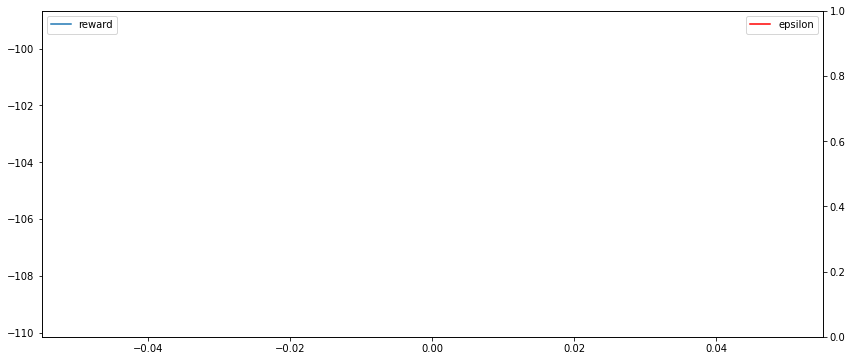

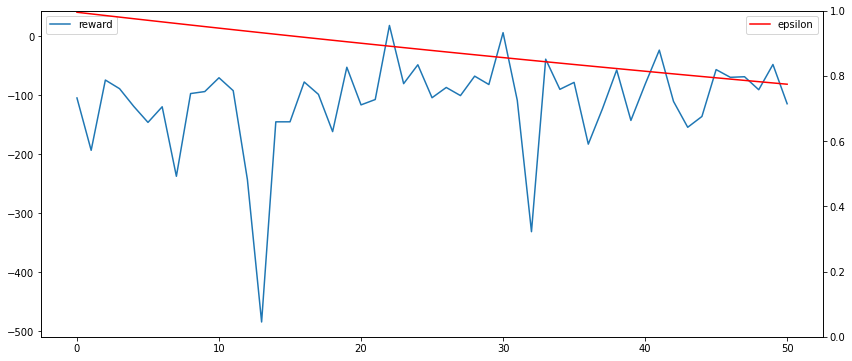

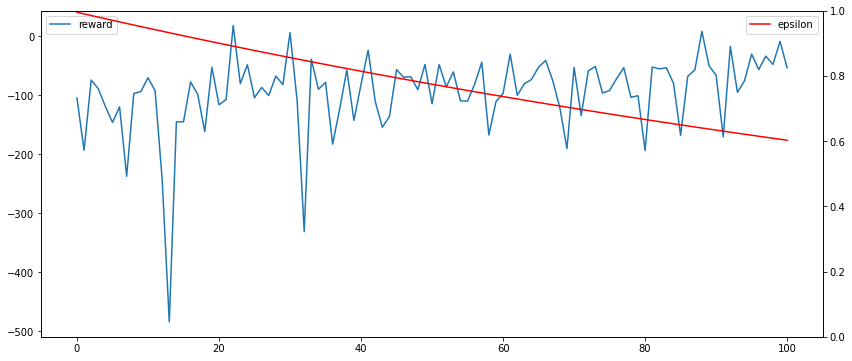

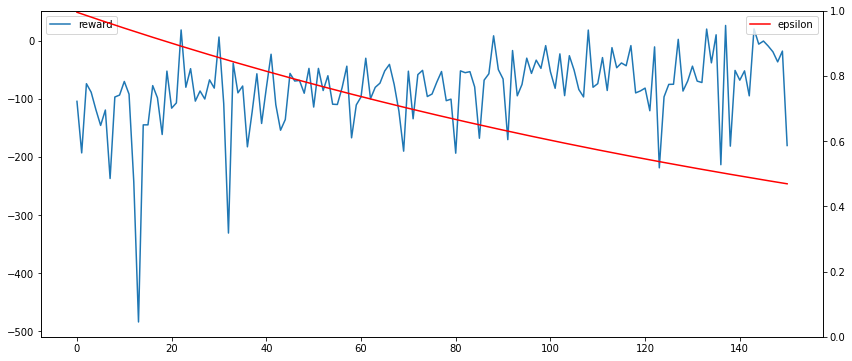

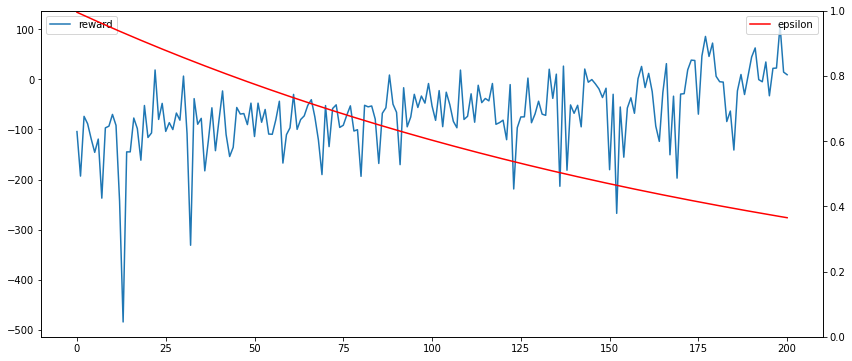

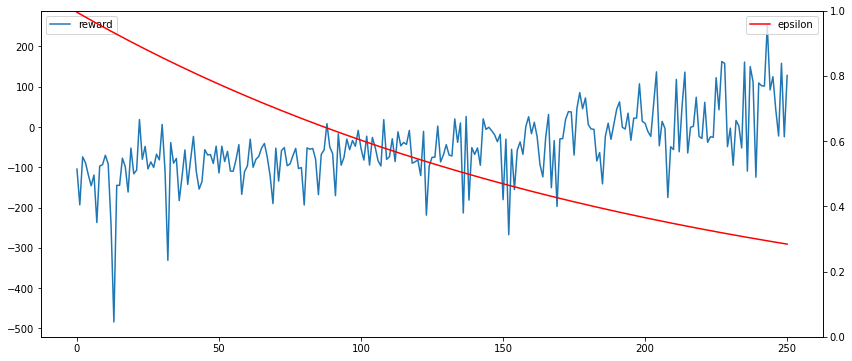

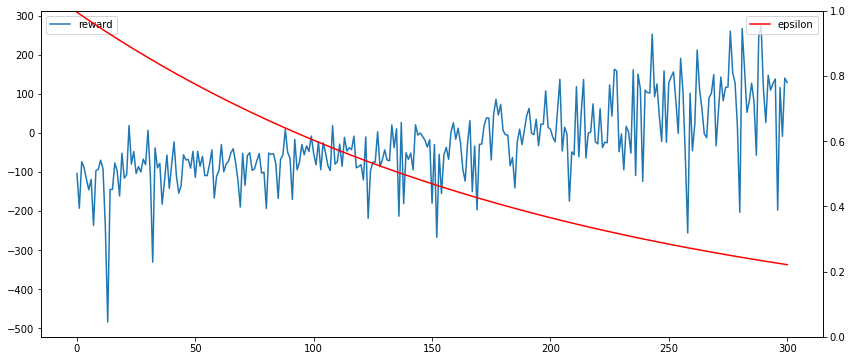

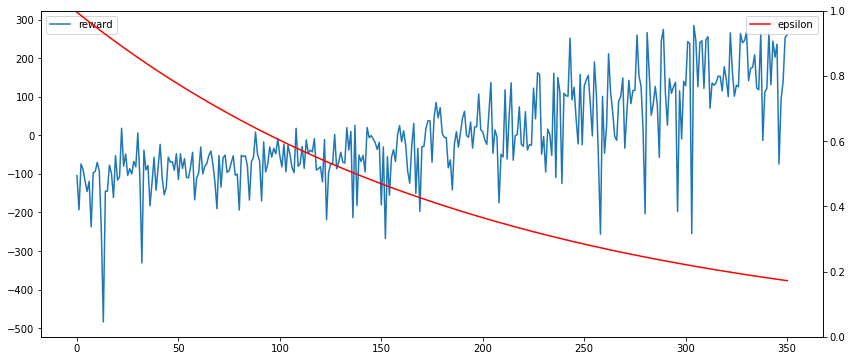

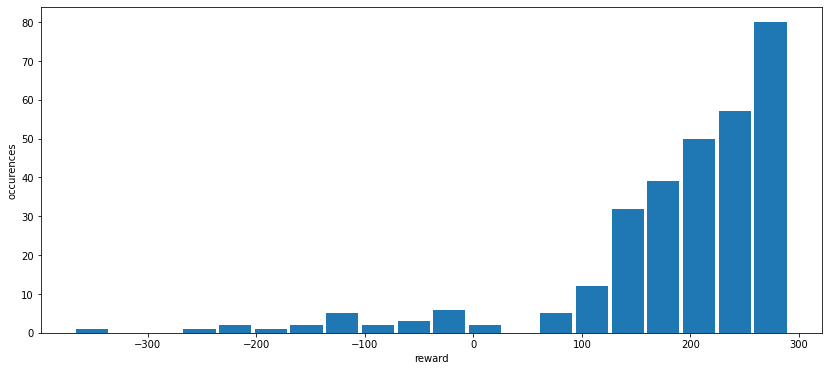

In [ ]:
summary_m = test_neural_agent(time_limit=15*60, episodes=1000, test_episodes=300,
                              use_memory=True, use_freeze=False, use_double=False)

Q-learning Agent with:
	- freezing

Time elapsed: 900.506s (15.0 min)
Average reward during training: 22.037171946621466
Finished episode #0
Finished episode #50
Finished episode #100
Finished episode #150
Finished episode #200
Finished episode #250
Average reward during testing: 123.51790289705752


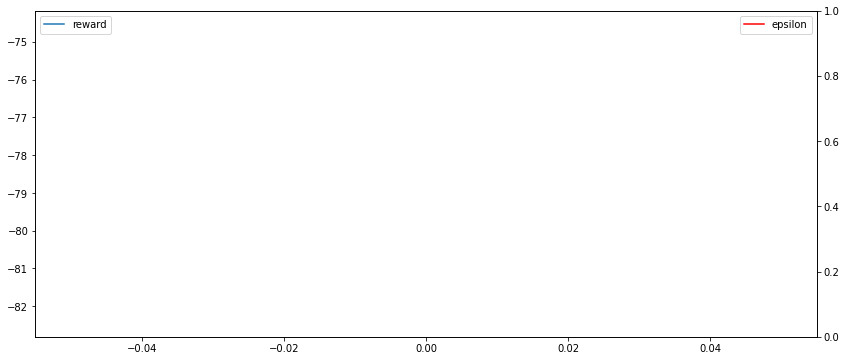

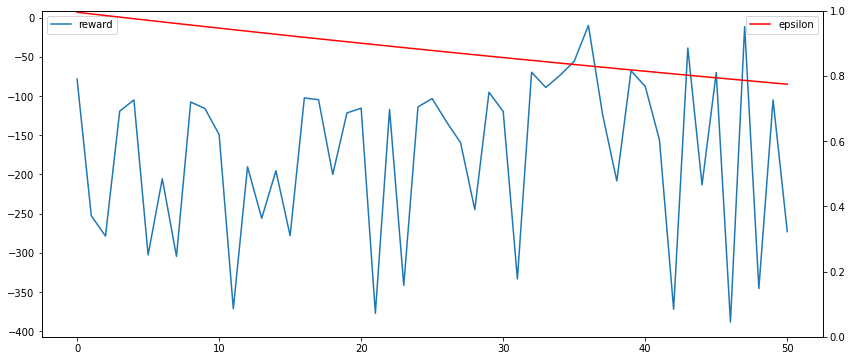

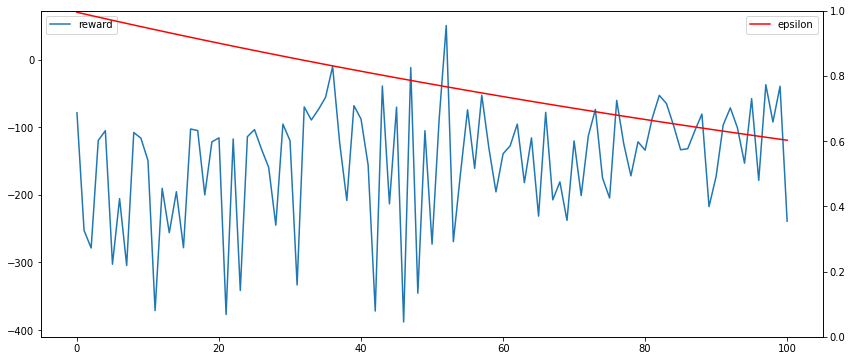

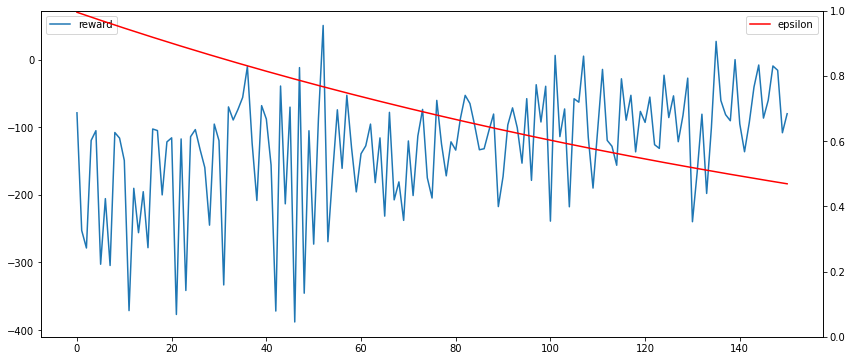

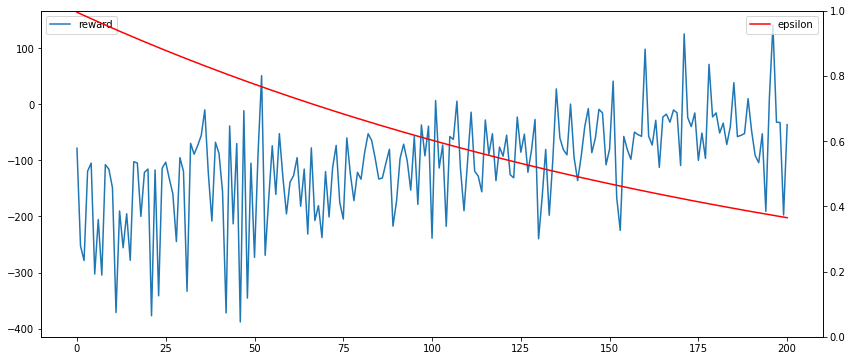

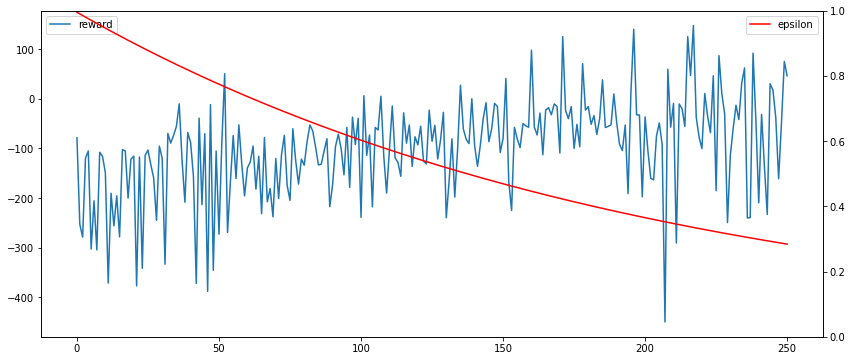

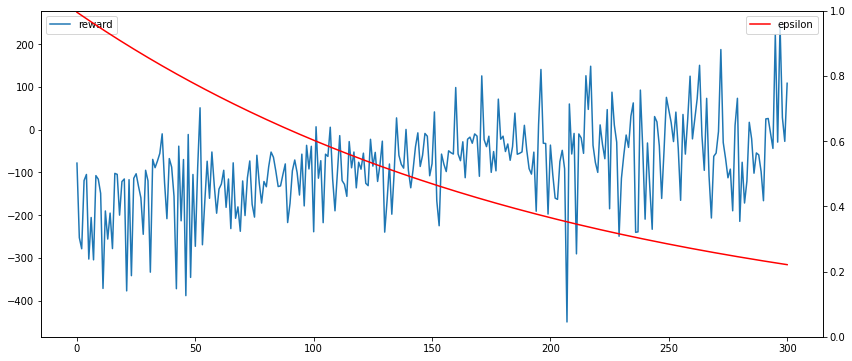

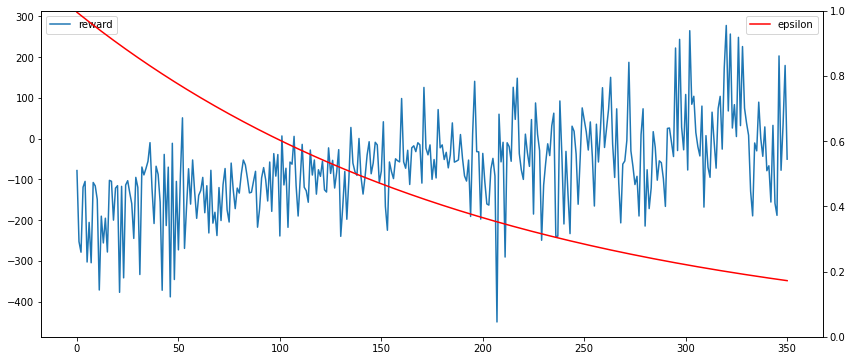

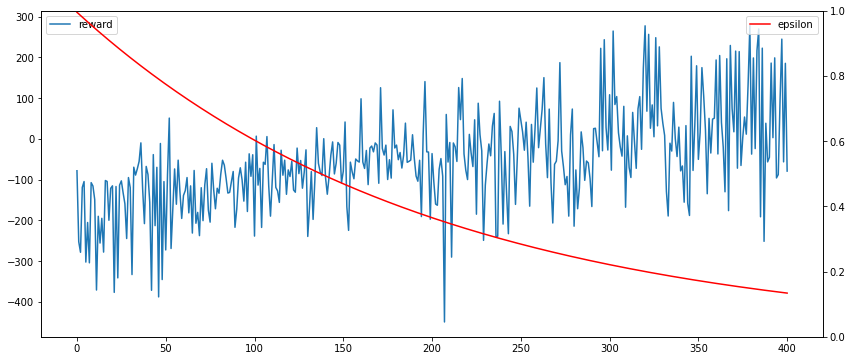

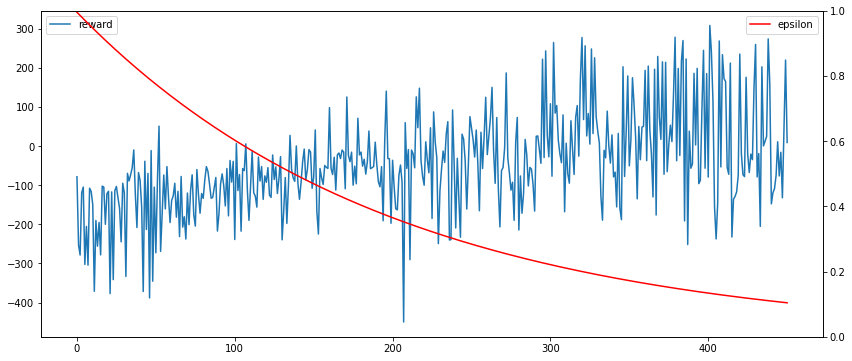

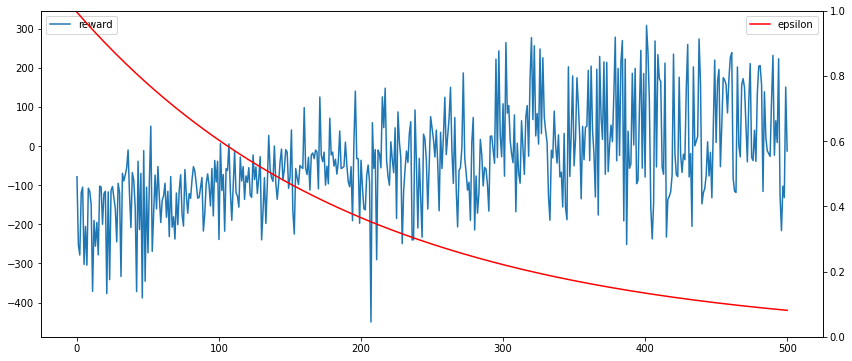

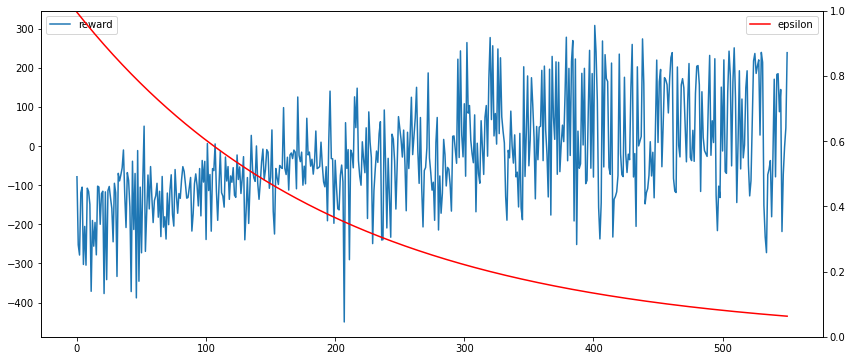

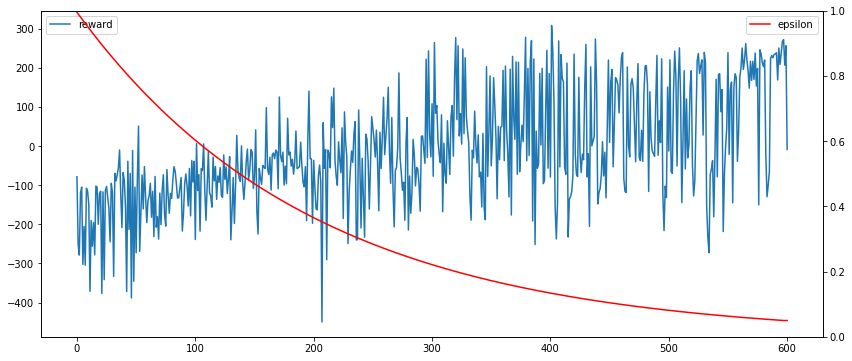

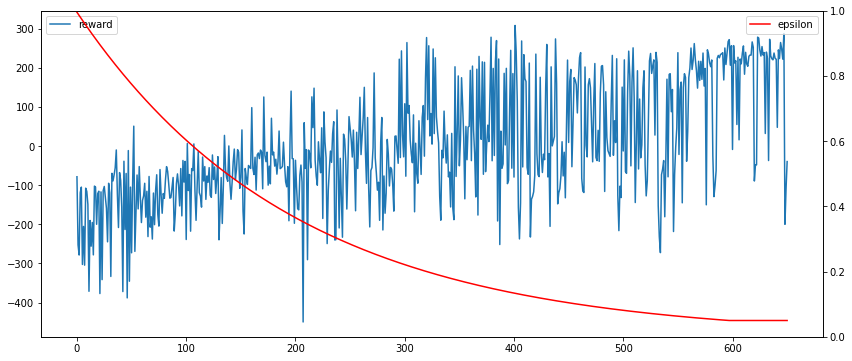

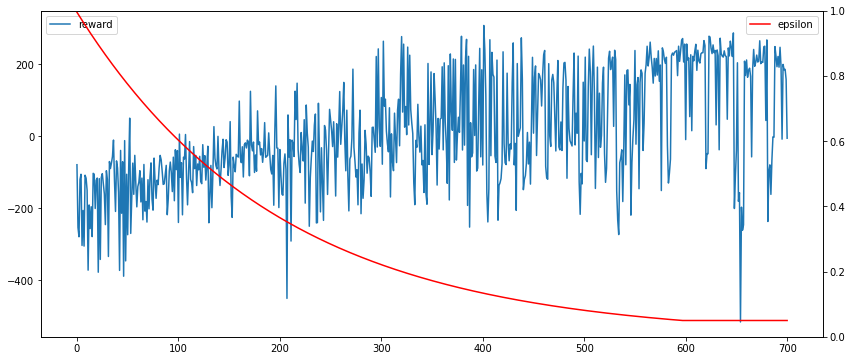

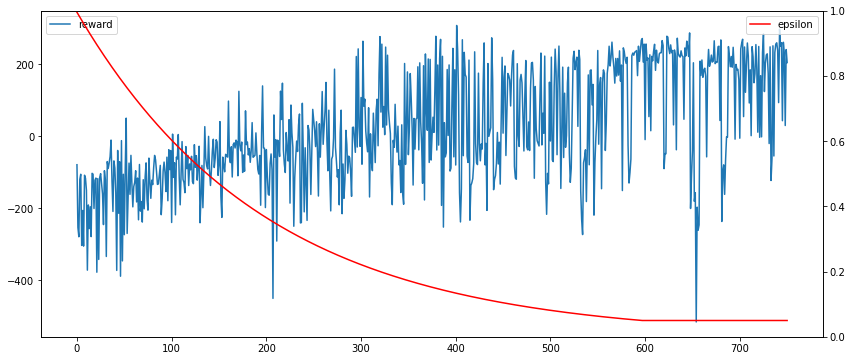

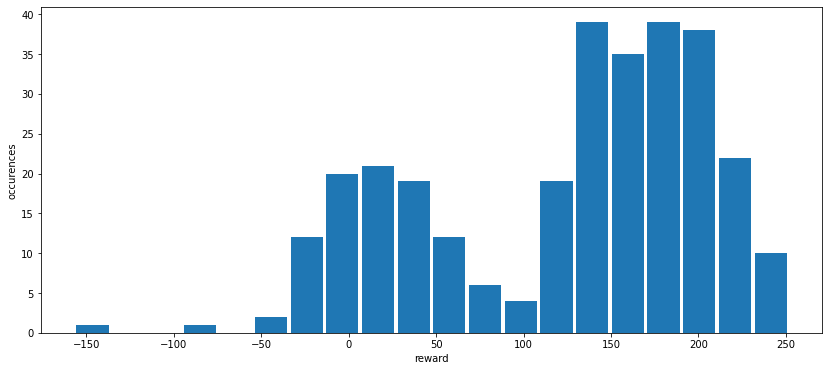

In [ ]:
summary_f = test_neural_agent(time_limit=15*60, episodes=1000, test_episodes=300,
                              use_memory=False, use_freeze=True, use_double=False)

Q-learning Agent with:
	- double Q

Time elapsed: 900.01s (15.0 min)
Average reward during training: 44.626790553350475
Finished episode #0
Finished episode #50
Finished episode #100
Finished episode #150
Finished episode #200
Finished episode #250
Average reward during testing: 156.59431184356708


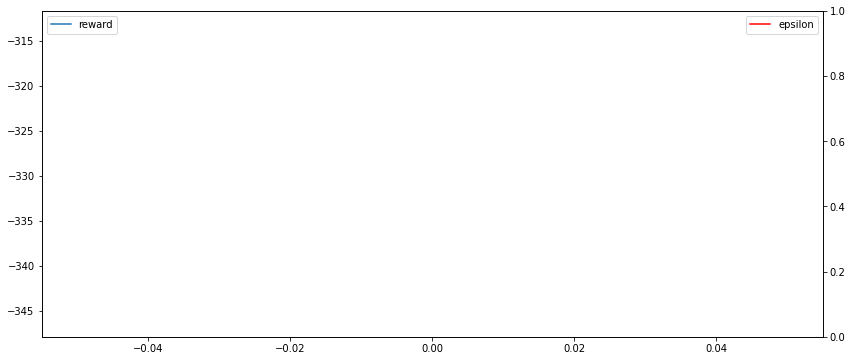

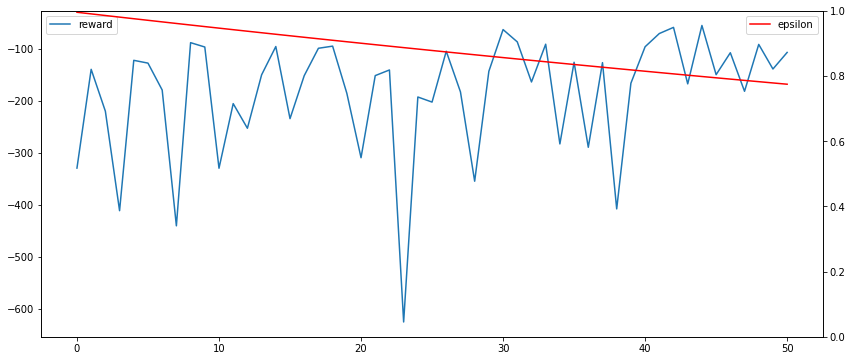

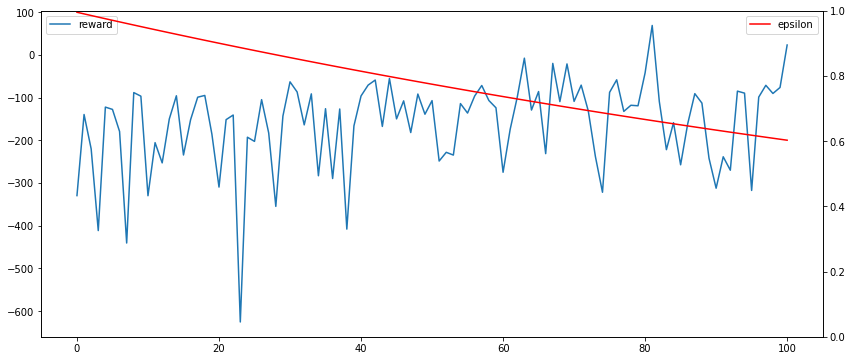

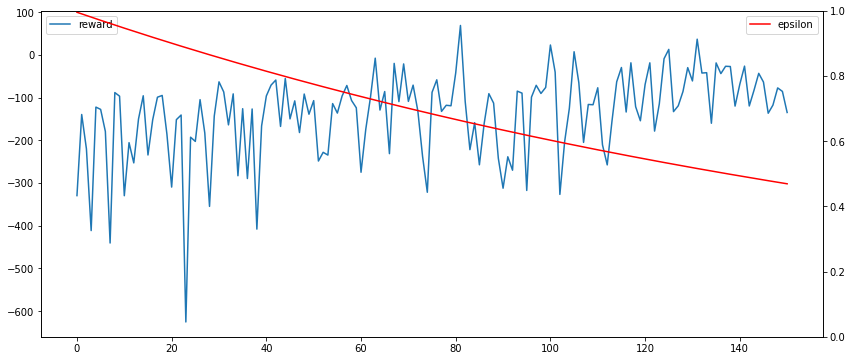

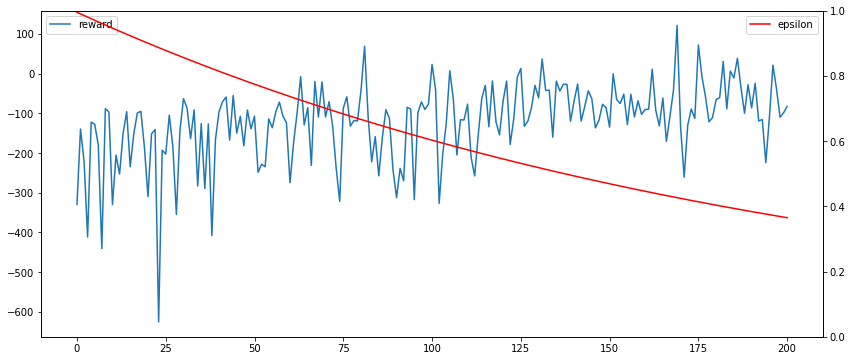

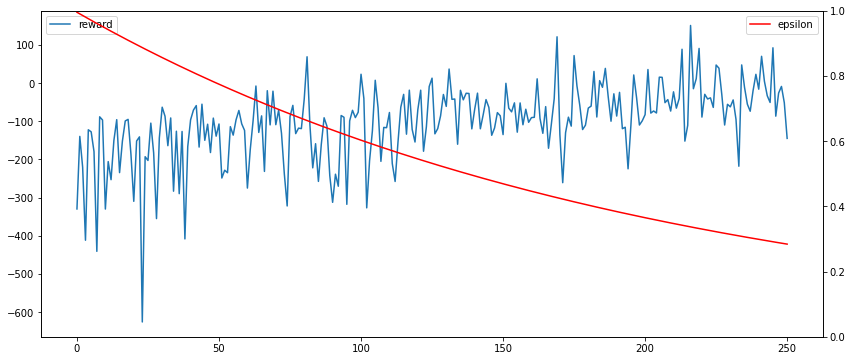

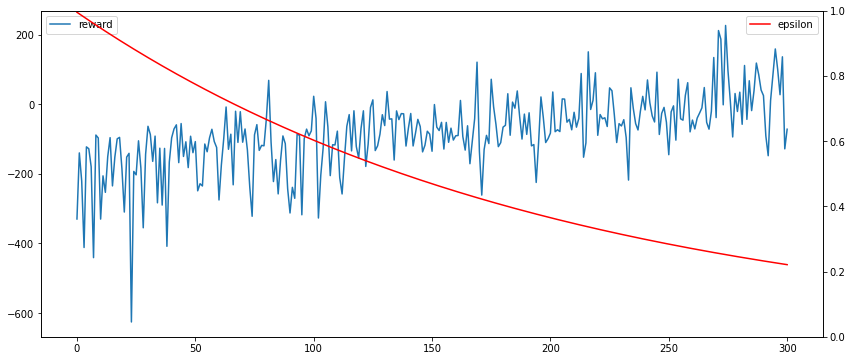

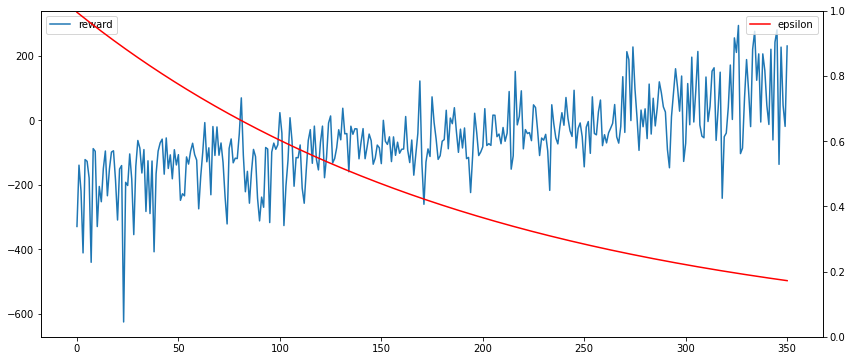

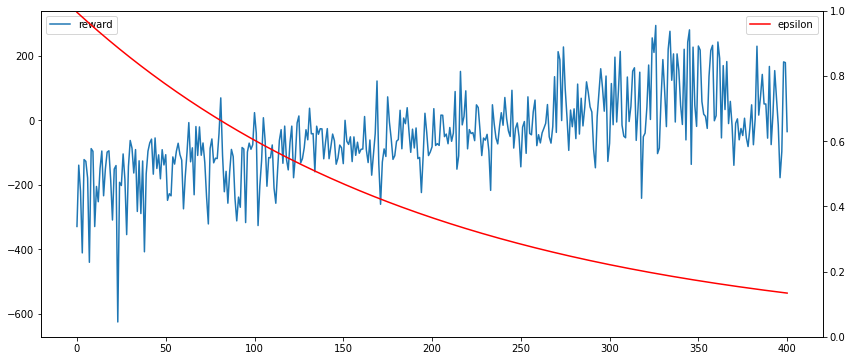

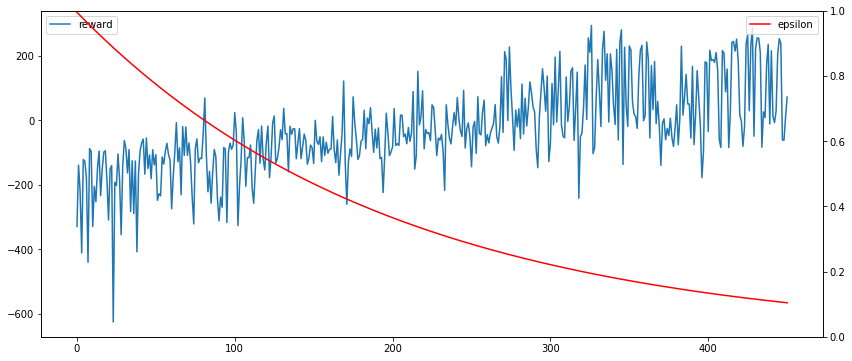

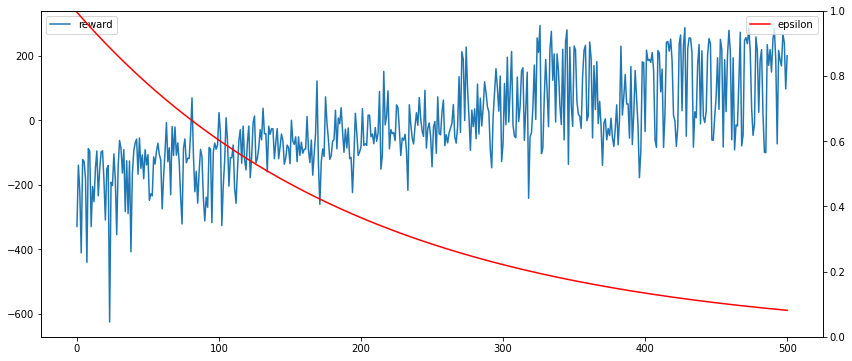

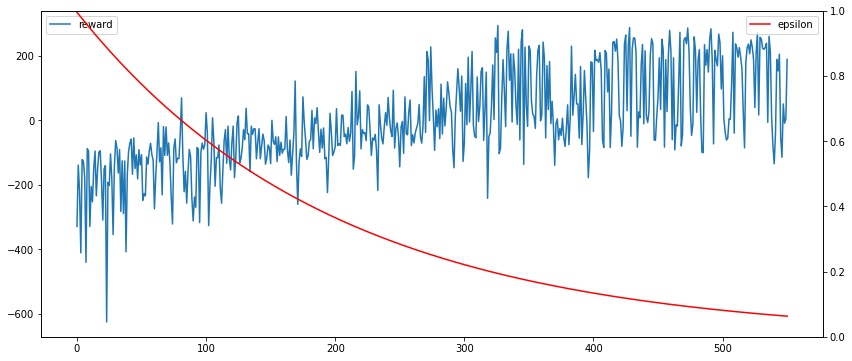

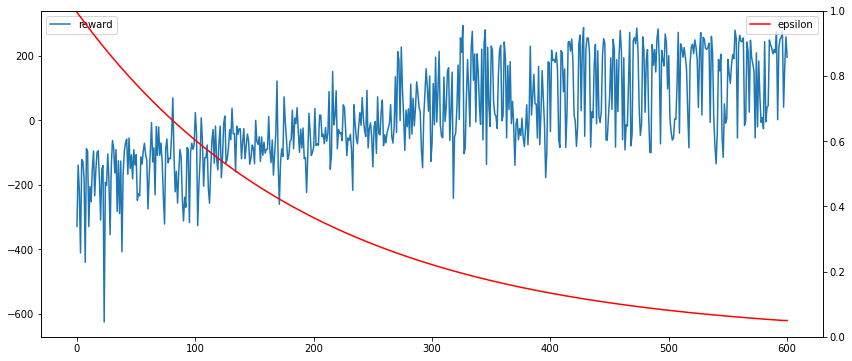

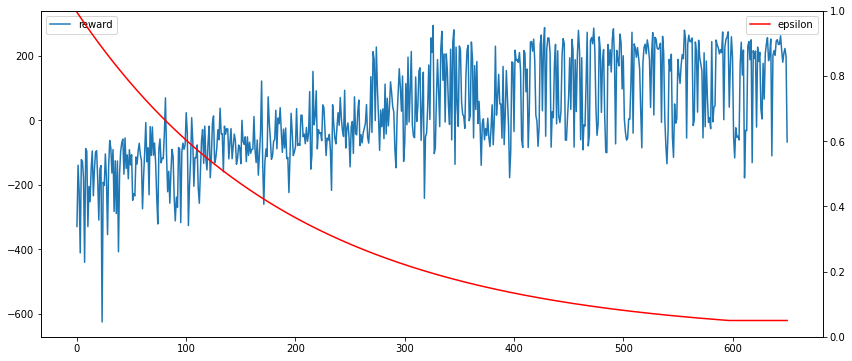

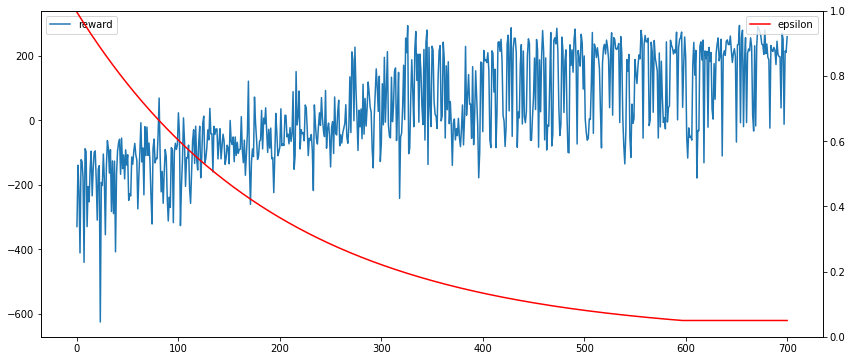

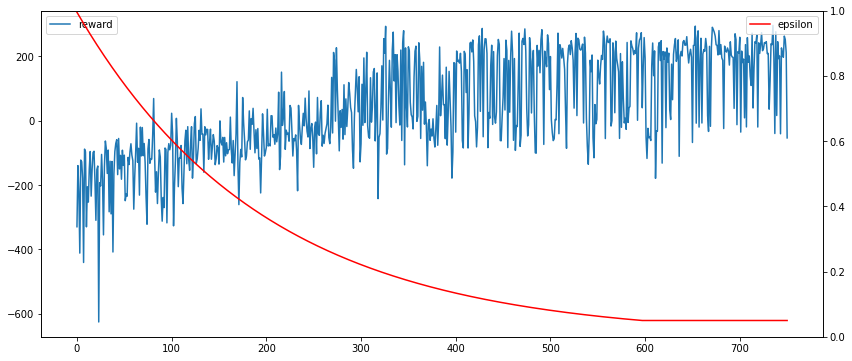

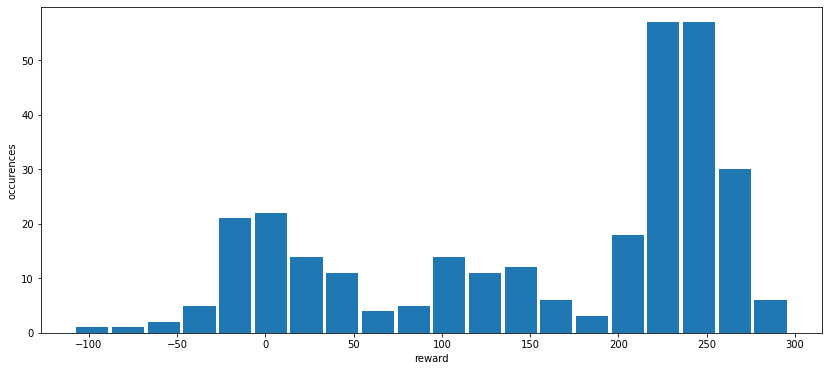

In [ ]:
summary_dq = test_neural_agent(time_limit=15*60, episodes=1000, test_episodes=300,
                              use_memory=False, use_freeze=False, use_double=True)

Q-learning Agent with:
	- memory
	- freezing
	- double Q

Time elapsed: 900.614s (15.0 min)
Average reward during training: 37.61265694943681
Finished episode #0
Finished episode #50
Finished episode #100
Finished episode #150
Finished episode #200
Finished episode #250
Average reward during testing: 207.23018171324418


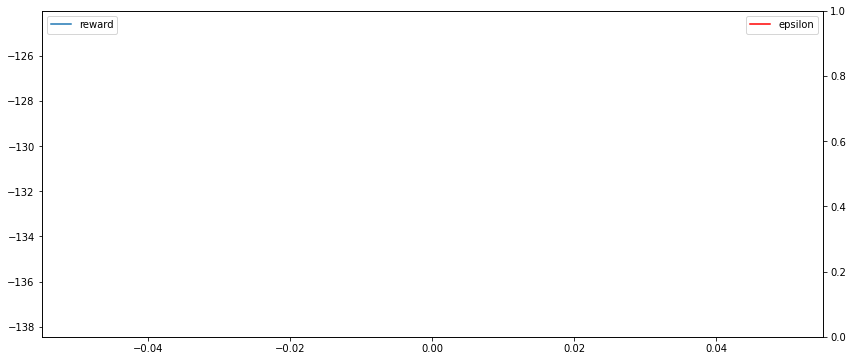

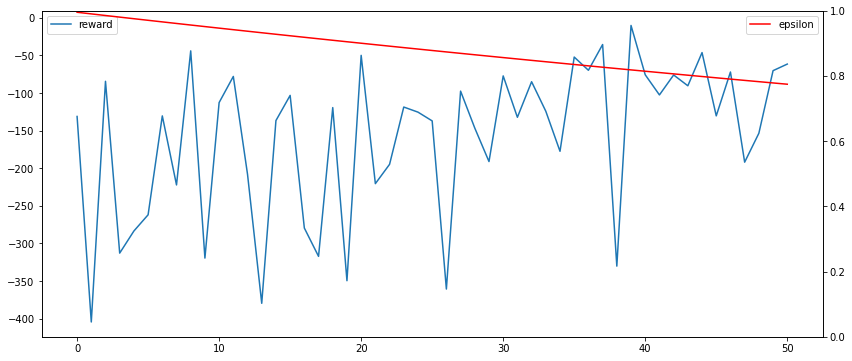

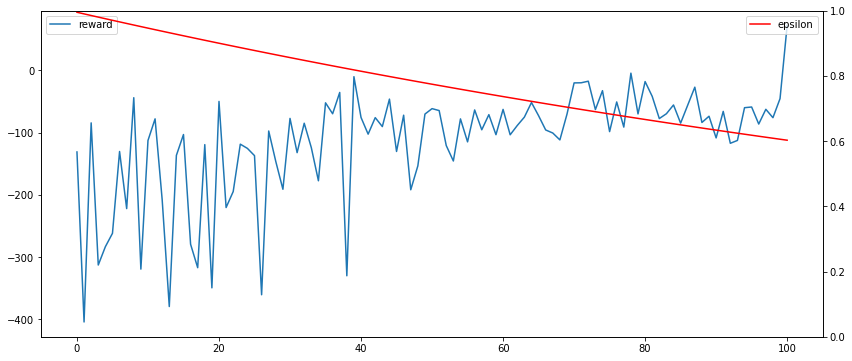

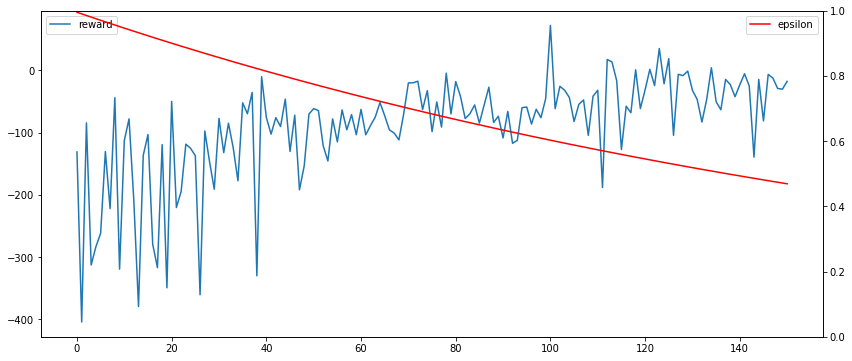

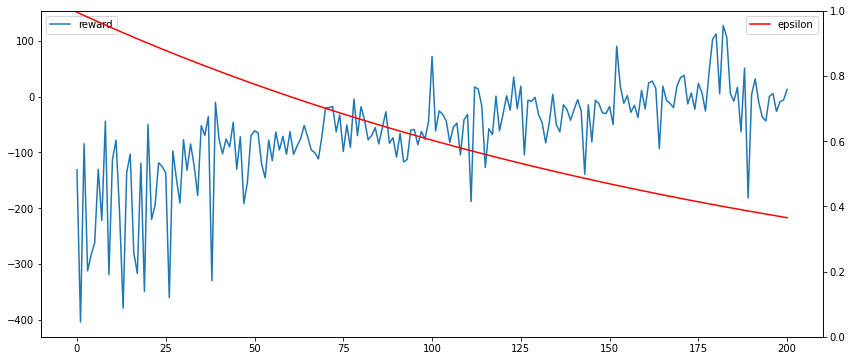

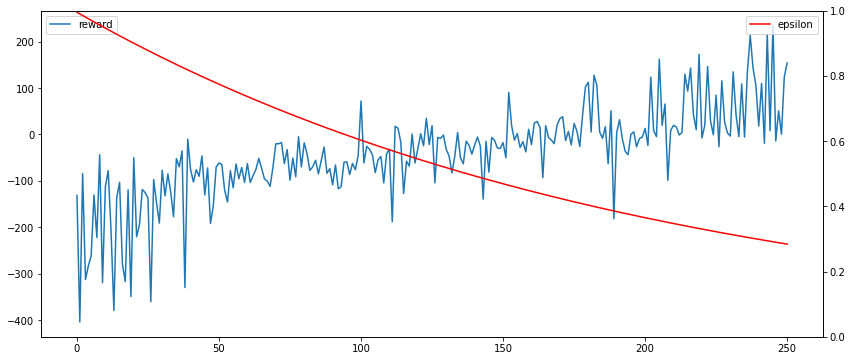

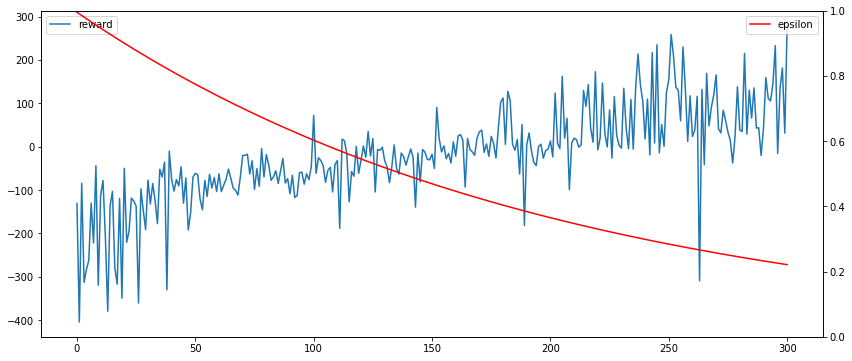

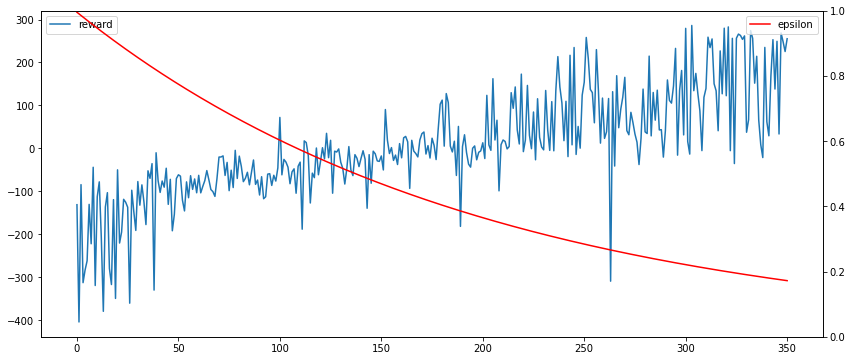

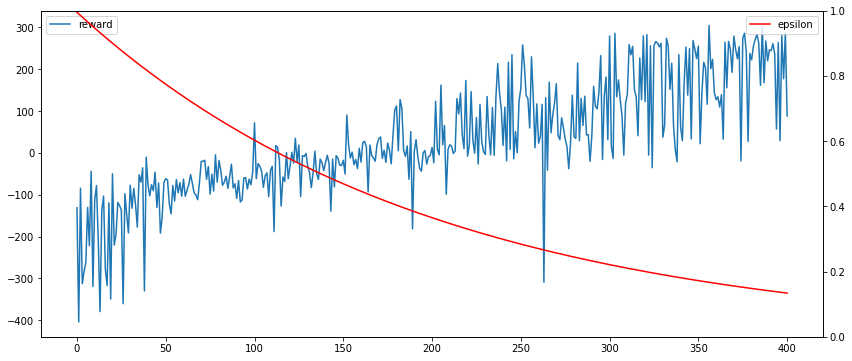

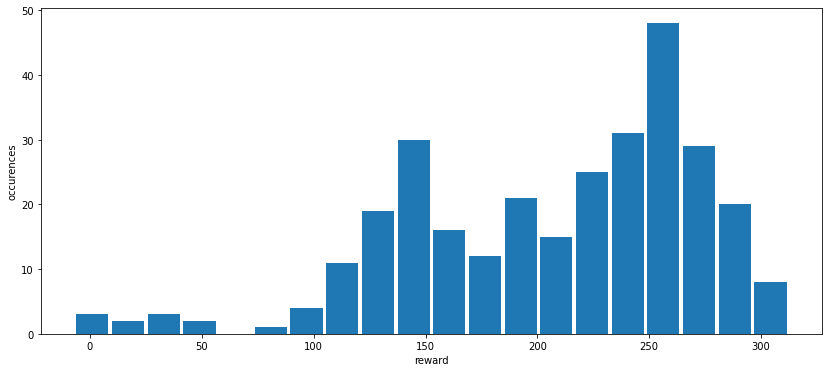

In [11]:
summary_mfdq = test_neural_agent(time_limit=15*60, episodes=1000, test_episodes=300,
                              use_memory=True, use_freeze=True, use_double=True)